In [ ]:
#!for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

In [214]:
import zipfile
import os
import numpy as np
import pandas as pd
import urllib
import urllib2
import geopandas as gpd
import matplotlib as plt
import matplotlib.cm as cm
import datetime as dt
import json
import pysal as psl
import shapefile

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from cStringIO import StringIO
from fiona.crs import from_epsg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Moving to PUIDATA

In [2]:
os.system("mv " + "zbp" + "00" + "totals.zip " + os.getenv("PUIDATA"))

256

In [3]:
os.system("mv " + "zbp" + "10" + "totals.zip " + os.getenv("PUIDATA"))

256

Similar to HW11 Assignment 2:

In [4]:
zc_shape = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
zc_shape.head()

@id  BLDGpostalCode CTY_FIPS  \
0  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
1  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
2  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
3  http://nyc.pediacities.com/Resource/PostalCode...               0      081   
4  http://nyc.pediacities.com/Resource/PostalCode...               0      081   

   OBJECTID          PO_NAME STATE ST_FIPS    Shape_Area    Shape_Leng  \
0         1  Jackson Heights    NY      36  2.016328e+07  20624.692317   
1         2        Glen Oaks    NY      36  2.260653e+07  23002.816039   
2         3    New Hyde Park    NY      36  6.269333e+06  15749.161511   
3         4        Bellerose    NY      36  4.941836e+07  35932.810639   
4         5    Fresh Meadows    NY      36  6.938587e+07  38693.565676   

  borough                                           geometry postalCode  
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...      11372  
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...      11004  
2  Queens  POLYGON ((-73.70098278625547 40.73889569923034...      11040  
3  Queens  POLYGON ((-73.72270447144122 40.75373371438336...      11426  
4  Queens  POLYGON ((-73.81088634744755 40.72717187575918...      11365

In [5]:
zc_shape.columns

Index([           u'@id', u'BLDGpostalCode',       u'CTY_FIPS',
             u'OBJECTID',        u'PO_NAME',          u'STATE',
              u'ST_FIPS',     u'Shape_Area',     u'Shape_Leng',
              u'borough',       u'geometry',     u'postalCode'],
      dtype='object')

In [6]:
zc_shape = zc_shape.drop(['@id','BLDGpostalCode','CTY_FIPS','ST_FIPS',
                                    'OBJECTID','PO_NAME','Shape_Leng','STATE',
                                     'ST_FIPS','borough','Shape_Leng'], axis = 1)
zc_shape = zc_shape.rename(columns={'postalCode' : 'zip'})
zc_shape.head()

Shape_Area                                           geometry    zip
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...  11372
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...  11004
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...  11040
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...  11426
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...  11365

Converting all the zip codes to numeric values

In [7]:
zc_shape['zip'] = pd.to_numeric(zc_shape['zip'])
zc_shape['zip']

0      11372
1      11004
2      11040
3      11426
4      11365
5      11373
6      11001
7      11375
8      11427
9      11374
10     11366
11     11423
12     11428
13     11432
14     11379
15     11429
16     11435
17     11415
18     11418
19     11433
20     11451
21     11221
22     11421
23     11419
24     11434
25     11216
26     11416
27     11233
28     11436
29     11213
       ...  
232    10106
233    10158
234    10041
235    10120
236    10278
237    10155
238    10022
239    10043
240    10081
241    10096
242    10097
243    10196
244    10196
245    10275
246    10265
247    10045
248    10047
249    10047
250    10080
251    10203
252    10259
253    10260
254    10285
255    10286
256    11370
257    10065
258    10075
259    10069
260    10281
261    10282
Name: zip, dtype: int64

Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

Table to show the merged table with the zip code of the businesses:

In [8]:
year = ['00', '10']

In [9]:
for i in year:
    zf = zipfile.ZipFile(os.getenv('PUIDATA')+ '/' + 'zbp'+ i +'totals.zip')
    business_data = pd.read_csv(zf.open('zbp' + i + 'totals.zip'.replace('.zip','.txt')))
    
    business_data.columns = map(str.lower, business_data.columns)
    business_data= business_data[['zip', 'est']]
    year = dt.datetime.strptime(str(i), '%y').year
    business_data.rename(columns={'est' : 'est'+str(i)}, inplace=True)
    zc_shape = zc_shape.merge(business_data, on = 'zip', how = 'inner')
    print("Year "+str(i)+'\n')
    print(business_data.head())
    print('\n')

Year 00

    zip  est00
0   501      1
1  1001    493
2  1002    563
3  1003     13
4  1004     48


Year 10

    zip  est10
0   501      2
1  1001    448
2  1002    570
3  1003     16
4  1004     21




In [10]:
zc_shape.head()

Shape_Area                                           geometry    zip  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...  11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...  11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...  11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...  11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...  11365   

   est00  est10  
0   1409   1629  
1    189    229  
2   1350   1494  
3    213    248  
4    553    643

Table 1: This shows the merged table with the zip code of the businesses 

Finding the Density:

Density = number of businesses/area of the zipcode

Area of the zip code:

In [13]:
zc_shape['cal_area'] = zc_shape.geometry.area

In [14]:
zc_shape.head()

Shape_Area                                           geometry    zip  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...  11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...  11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...  11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...  11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...  11365   

   est00  est10  cal_area  
0   1409   1629  0.000200  
1    189    229  0.000224  
2   1350   1494  0.000062  
3    213    248  0.000489  
4    553    643  0.000688

To calculate the density of both the years: 

In [15]:
zc_shape['density2000'] = zc_shape['est00'] / zc_shape['cal_area']
zc_shape['density2010'] = zc_shape['est10'] / zc_shape['cal_area']

In [16]:
zc_shape.head()

Shape_Area                                           geometry    zip  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...  11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...  11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...  11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...  11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...  11365   

   est00  est10  cal_area   density2000   density2010  
0   1409   1629  0.000200  7.045865e+06  8.146000e+06  
1    189    229  0.000224  8.433038e+05  1.021781e+06  
2   1350   1494  0.000062  2.176227e+07  2.408358e+07  
3    213    248  0.000489  4.354292e+05  5.069786e+05  
4    553    643  0.000688  8.041634e+05  9.350399e+05

Dividing the value so that it could be understood 

In [17]:
zc_shape['density2000'] = zc_shape['density2000']/10000
zc_shape['density2010'] = zc_shape['density2010']/10000

In [18]:
zc_shape.head()

Shape_Area                                           geometry    zip  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...  11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...  11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...  11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...  11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...  11365   

   est00  est10  cal_area  density2000  density2010  
0   1409   1629  0.000200   704.586533   814.600044  
1    189    229  0.000224    84.330384   102.178084  
2   1350   1494  0.000062  2176.227439  2408.358366  
3    213    248  0.000489    43.542923    50.697864  
4    553    643  0.000688    80.416343    93.503994

In [19]:
zc_shape = zc_shape.rename(columns={'est00' : 'Year_2000'})
zc_shape = zc_shape.rename(columns={'est10' : 'Year_2010'})
zc_shape.head()
#for proper and clear naming

Shape_Area                                           geometry    zip  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...  11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...  11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...  11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...  11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...  11365   

   Year_2000  Year_2010  cal_area  density2000  density2010  
0       1409       1629  0.000200   704.586533   814.600044  
1        189        229  0.000224    84.330384   102.178084  
2       1350       1494  0.000062  2176.227439  2408.358366  
3        213        248  0.000489    43.542923    50.697864  
4        553        643  0.000688    80.416343    93.503994

In [ ]:
#ch1 = zc_shape(column='density2000', scheme='QUANTILES', k=3, colormap='OrRd', legend=True)

Showing density in a choropleth - where each zip code is a different color based on the density. 

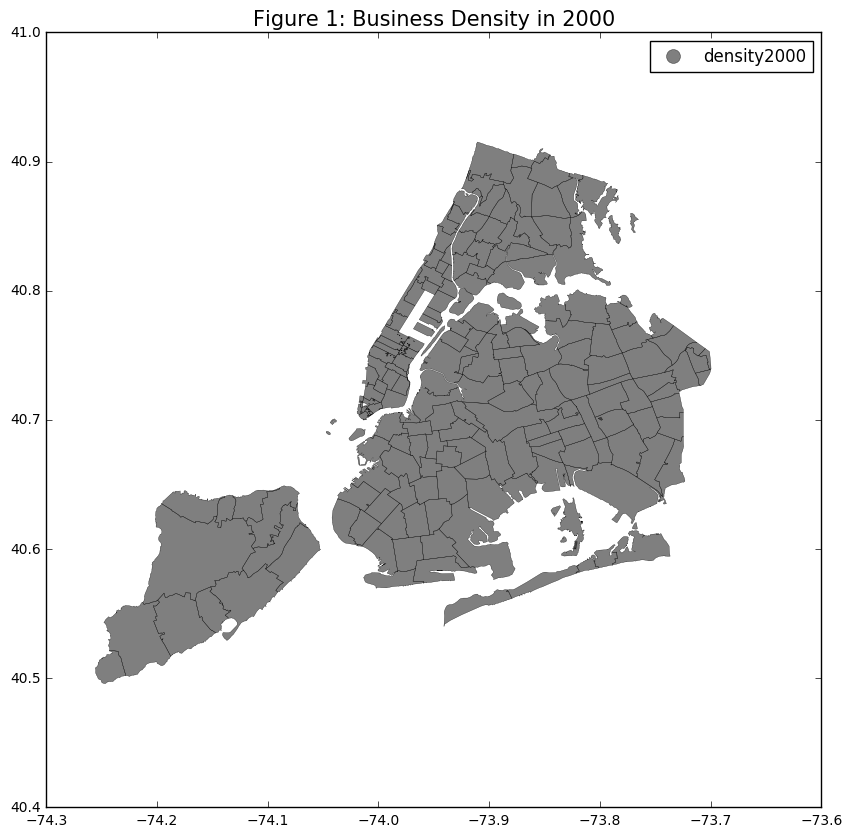

In [165]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
zc_shape.assign(cl='density2000').plot(column='cl', categorical=True, 
        k=6, cmap='spectral',ax=ax, linewidth=0.2, edgecolor='black', legend=True,)
ax.set_title("Figure 1: Business Density in 2000", fontsize = '15')

Since it is showing the same values everywere, I will have to divide it into quartiles.

http://nullege.com/codes/search/pysal.Quantiles - psl.quantiles

In [20]:
density_2000 = psl.Quantiles(zc_shape['density2000'], k = 6)
density_2000

                   Quantiles                    
 
  Lower                Upper               Count
             x[i] <=     70.061               42
    70.061 < x[i] <=    153.326               42
   153.326 < x[i] <=    259.418               41
   259.418 < x[i] <=    725.621               42
   725.621 < x[i] <=  10813.454               41
 10813.454 < x[i] <= 162907.869               42

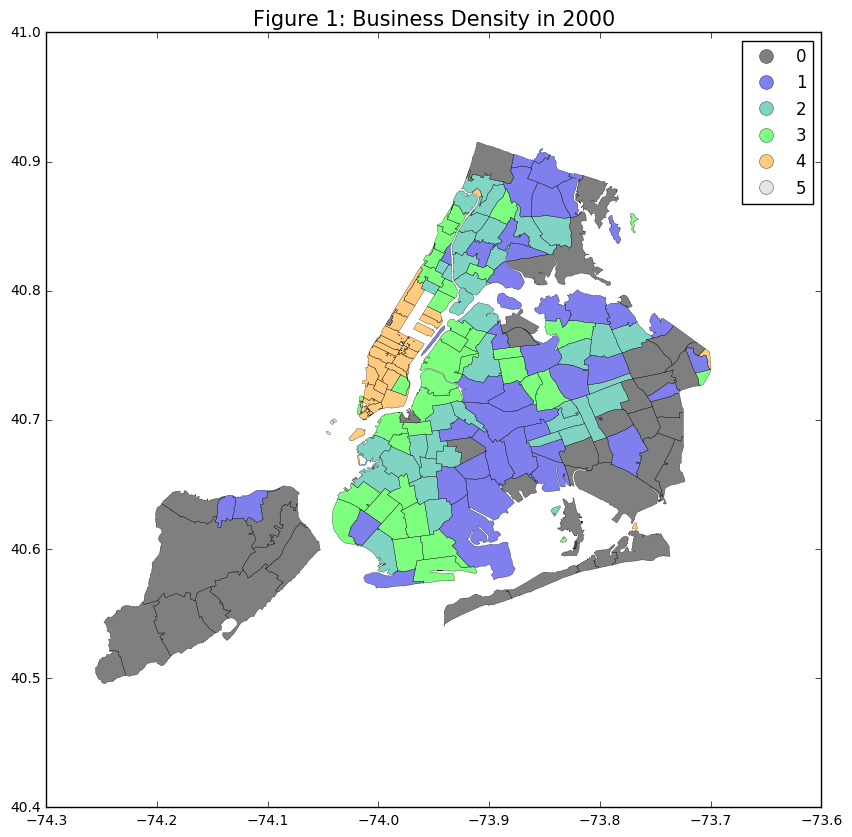

In [166]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
zc_shape.assign(cl=density_2000.yb).plot(column='cl', categorical=True, 
        k=6, cmap='spectral',ax=ax, linewidth=0.2, edgecolor='black', legend=True,)
ax.set_title("Figure 1: Business Density in 2000", fontsize = '15')

Figure 1: The figure above shows the business density in the year 2000. Based on the map, we can say that the business density in 2000 was the highest in Manhattan (excluding uptown - Harlem, Washington Heights etc.) and lowest in Staten Island.

In [22]:
density_2010 = psl.Quantiles(zc_shape['density2010'], k = 6)
density_2010

                   Quantiles                    
 
  Lower                Upper               Count
             x[i] <=     82.823               42
    82.823 < x[i] <=    193.845               42
   193.845 < x[i] <=    322.799               41
   322.799 < x[i] <=    882.453               42
   882.453 < x[i] <=   7247.362               41
  7247.362 < x[i] <= 133062.153               42

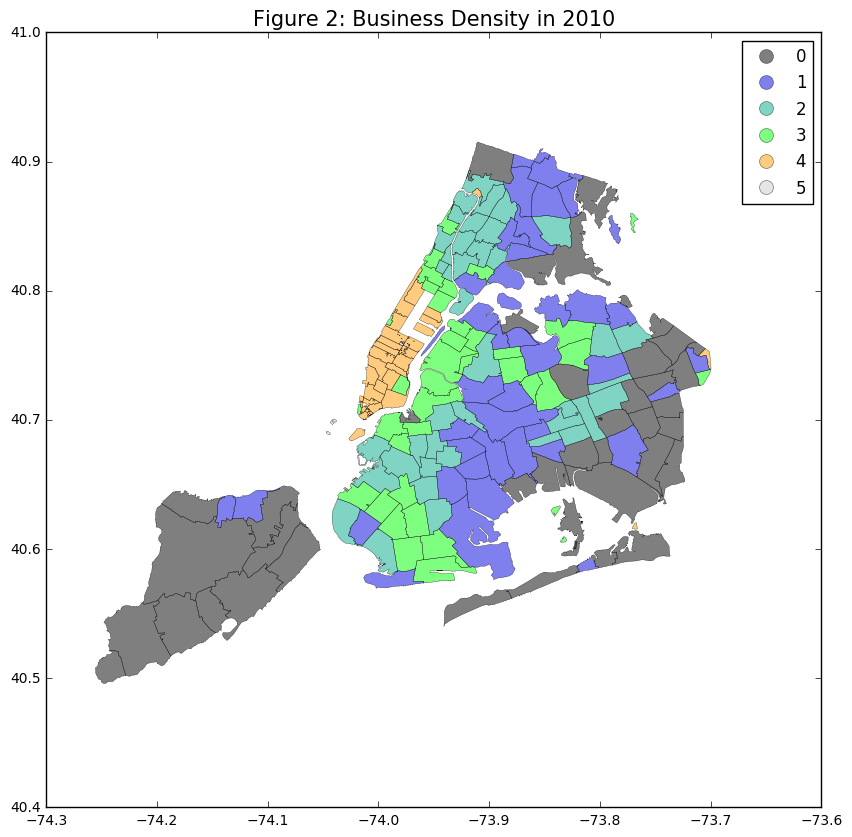

In [167]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
zc_shape.assign(cl=density_2010.yb).plot(column='cl', categorical=True, 
        k=6, cmap='spectral',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure 2: Business Density in 2010", fontsize = '15')

Figure 2: The figure above shows the business density in the year 2010. A lot has not changed in the year 2010 compared to 2000, i.e. the business density in 2010 was still the highest in Manhattan (excluding uptown - Harlem, Washington Heights etc.) and lowest in Staten Island.

Comparing the densities in both the years: 

In [139]:
zc_shape['density_diff'] = zc_shape['density2010'] - zc_shape['density2000']
zc_shape.head()

Shape_Area                                           geometry    zip  \
0  2.016328e+07  POLYGON ((-73.86942457284175 40.74915687096787...  11372   
1  2.260653e+07  POLYGON ((-73.71068374074007 40.75004039450917...  11004   
2  6.269333e+06  POLYGON ((-73.70098278625547 40.73889569923034...  11040   
3  4.941836e+07  POLYGON ((-73.72270447144122 40.75373371438336...  11426   
4  6.938587e+07  POLYGON ((-73.81088634744755 40.72717187575918...  11365   

   Year_2000  Year_2010  cal_area  density2000  density2010  density_diff  
0       1409       1629  0.000200   704.586533   814.600044    110.013511  
1        189        229  0.000224    84.330384   102.178084     17.847700  
2       1350       1494  0.000062  2176.227439  2408.358366    232.130927  
3        213        248  0.000489    43.542923    50.697864      7.154940  
4        553        643  0.000688    80.416343    93.503994     13.087651

In [25]:
density_diff = psl.Quantiles(zc_shape['density_diff'], k = 6)
density_diff

                  Quantiles                   
 
  Lower              Upper               Count
            x[i] <=  -228.744               42
 -228.744 < x[i] <=     8.977               42
    8.977 < x[i] <=    22.132               41
   22.132 < x[i] <=    53.691               42
   53.691 < x[i] <=   112.595               41
  112.595 < x[i] <= 20404.950               42

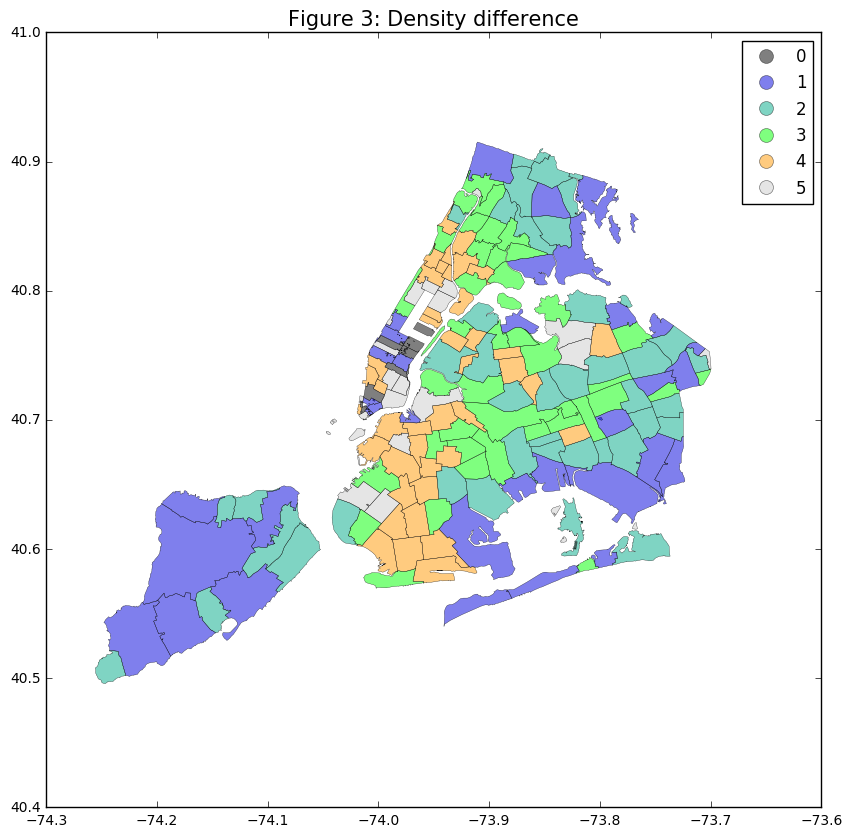

In [168]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
zc_shape.assign(cl=density_diff.yb).plot(column='cl', categorical=True, 
      k=6, cmap='spectral',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure 3: Density difference", fontsize = '15')

Figure 3: The figure above shows the difference in the business density between both the years. According to the figure, majority of the difference has been in uptown Manhattan - east and west side.

Loading all the census data

In [27]:
SQL_SOURCE = 'https://fb55.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """queries data from CartoDB SQL database
    Arguments:
    query: a string like 
            SELECT colum_name_1, column_name_2 FROM database_name
    format: the file format (e.g. CSV, GeoJson)
    source: the sql database url link
    Return:
        database as a string to be read in with the appropriate function
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [28]:
query = "SELECT * FROM table_2010_census_tracts"

In [29]:
data_census = queryCartoDB(query, format='GeoJSON')
dgeo = json.loads(data_census.read())
census_tract = gp.GeoDataFrame.from_features(dgeo['features'])
census_tract.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  
0                              Flatbush  4015  1110945.63082  4305.94762341  
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209  
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952  
3                            Whitestone  4103  11557974.9909  17092.0365078  
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859

In [30]:
countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}

In [141]:
census_tract['codes'] = list(zip(census_tract.boro_name, census_tract.ct_2010))
census_tract['geo_id']  = census_tract[['codes']].applymap(lambda x:
                                    ("1400000US36%03d%06d"%(int(countyID[x[0]]),int(x[1]))))

In [32]:
census_tract.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

                codes                geo_id  
0  (Brooklyn, 050804)  1400000US36047050804  
1  (Brooklyn, 027500)  1400000US36047027500  
2     (Bronx, 009200)  1400000US36005009200  
3    (Queens, 099100)  1400000US36081099100  
4    (Queens, 000100)  1400000US36081000100

In [33]:
qu_2000 = "SELECT geo_id, hc01_vc01, hc02_vc29, hc01_vc18 FROM dec_00_sf1_dp1"

In [147]:
datastream = queryCartoDB(query, format='GeoJSON')
datageo = json.loads(datastream.read())
census_00 = gpd.GeoDataFrame.from_features(datageo['features'])
census_00.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  
0                              Flatbush  4015  1110945.63082  4305.94762341  
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209  
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952  
3                            Whitestone  4103  11557974.9909  17092.0365078  
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859

In [148]:
census_00 = census_00.rename(columns = {"hc01_vc01":"Total_pop","hc01_vc18":"Age_median","hc02_vc29":"White_Pop(%)"})
census_00.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  
0                              Flatbush  4015  1110945.63082  4305.94762341  
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209  
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952  
3                            Whitestone  4103  11557974.9909  17092.0365078  
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859

In [149]:
qu_2010 = "SELECT geo_id, hd01_s001, hd01_s020, hd02_s078 FROM dec_10_sf1_sf1dp1"

In [152]:
data_census = queryCartoDB(qu_2010, format='JSON')
dgeo = json.loads(data_census.read())
census_10 = gp.GeoDataFrame.from_dict(dgeo['rows'])
census_10.head()

geo_id hd01_s001 hd01_s020 hd02_s078
0  1400000US36081038301         0         0          
1  1400000US36005002400         4        38        50
2  1400000US36059990200         0         0          
3  1400000US36059990400         0         0          
4  1400000US36007012900      1532      59.8      98.2

In [153]:
census_10 = census_10.rename(columns = {"hd01_s001":"Total_pop","hd01_s020":"Age_median","hd02_s078":"White_Pop(%)"})
census_10.head()

geo_id Total_pop Age_median White_Pop(%)
0  1400000US36081038301         0          0             
1  1400000US36005002400         4         38           50
2  1400000US36059990200         0          0             
3  1400000US36059990400         0          0             
4  1400000US36007012900      1532       59.8         98.2

Collecting the income data:

In [154]:
qu_income_00 = "SELECT geo_id, hc01_vc64 FROM dec_00_sf3_dp3_with_ann"

In [156]:
data_census = queryCartoDB(qu_income_00, format='JSON')
dgeo = json.loads(data_census.read())
census_income_00 = gp.GeoDataFrame.from_dict(dgeo['rows'])
census_income_00.head()

geo_id  hc01_vc64
0  1400000US36089991900          0
1  1400000US36001013703      68929
2  1400000US36005000200      42539
3  1400000US36005002400          0
4  1400000US36029001301          0

In [157]:
census_income_00 = census_income_00.rename(columns = {"hc01_vc64":"Median_Income"})
census_income_00.head()

geo_id  Median_Income
0  1400000US36089991900              0
1  1400000US36001013703          68929
2  1400000US36005000200          42539
3  1400000US36005002400              0
4  1400000US36029001301              0

In [158]:
qu_income_10 = "SELECT geo_id, hc01_est_vc13 FROM acs_10_5yr_s1901_with_ann"

In [159]:
data_census = queryCartoDB(qu_income_10, format='JSON')
dgeo = json.loads(data_census.read())
census_income_10 = gp.GeoDataFrame.from_dict(dgeo['rows'])
census_income_10.head()

geo_id hc01_est_vc13
0  1400000US36001000100         32333
1  1400000US36001000200         25354
2  1400000US36001000300         30932
3  1400000US36001000401         60909
4  1400000US36001000403         52807

In [160]:
census_income_10 = census_income_10.rename(columns = {"hc01_est_vc13":"Median_Income"})
census_income_10.head()

geo_id Median_Income
0  1400000US36001000100         32333
1  1400000US36001000200         25354
2  1400000US36001000300         30932
3  1400000US36001000401         60909
4  1400000US36001000403         52807

In [45]:
print (census_income_10.dtypes)

geo_id           object
Median_Income    object
dtype: object


Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

Common column = geo_id

Merging step by step

In [46]:
merge_2000_10 = pd.merge(census_tract, census_00, on = 'geo_id')
merge_2000_10.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3027500  Brooklyn        1261          I  027500     275   
1         2      2009200     Bronx        1294          E  009200      92   
2         4      4099100    Queens        1306          I  099100     991   
3         4      4000100    Queens        1407          I  000100       1   
4         3      3024100  Brooklyn        1425          E  024100     241   

                                            geometry ntacode  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...    BK75   

                                ntaname  puma     shape_area     shape_leng  \
0                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
1                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
2                            Whitestone  4103  11557974.9909  17092.0365078   
3  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   
4                               Bedford  4003  1939949.84007  5837.00532323   

                codes                geo_id Total_pop Age_median White_Pop(%)  
0  (Brooklyn, 027500)  1400000US36047027500      4171       33.9          1.5  
1     (Bronx, 009200)  1400000US36005009200      4877       31.7         30.1  
2    (Queens, 099100)  1400000US36081099100      6659       47.1         87.7  
3    (Queens, 000100)  1400000US36081000100      1370       41.3         55.4  
4  (Brooklyn, 024100)  1400000US36047024100      1564       36.2         10.4

In [47]:
merge_00 = pd.merge(merge_2000_10, census_income_00, on = 'geo_id')
merge_00.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3027500  Brooklyn        1261          I  027500     275   
1         2      2009200     Bronx        1294          E  009200      92   
2         4      4099100    Queens        1306          I  099100     991   
3         4      4000100    Queens        1407          I  000100       1   
4         3      3024100  Brooklyn        1425          E  024100     241   

                                            geometry ntacode  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...    BK75   

                                ntaname  puma     shape_area     shape_leng  \
0                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
1                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
2                            Whitestone  4103  11557974.9909  17092.0365078   
3  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   
4                               Bedford  4003  1939949.84007  5837.00532323   

                codes                geo_id Total_pop Age_median White_Pop(%)  \
0  (Brooklyn, 027500)  1400000US36047027500      4171       33.9          1.5   
1     (Bronx, 009200)  1400000US36005009200      4877       31.7         30.1   
2    (Queens, 099100)  1400000US36081099100      6659       47.1         87.7   
3    (Queens, 000100)  1400000US36081000100      1370       41.3         55.4   
4  (Brooklyn, 024100)  1400000US36047024100      1564       36.2         10.4   

   Median_Income  
0          30241  
1          36589  
2          62341  
3          85898  
4          10500

In [48]:
merge_00.columns


Index([    u'boro_code',  u'boro_ct_2010',     u'boro_name',    u'cartodb_id',
          u'cdeligibil',       u'ct_2010',       u'ctlabel',      u'geometry',
             u'ntacode',       u'ntaname',          u'puma',    u'shape_area',
          u'shape_leng',         u'codes',        u'geo_id',     u'Total_pop',
          u'Age_median',  u'White_Pop(%)', u'Median_Income'],
      dtype='object')

In [49]:
merge_00 = merge_00.drop(['boro_code', 'boro_ct_2010', 'boro_name', 'cartodb_id','cdeligibil', 'ct_2010', 'ctlabel', 
                          'ntacode', 'ntaname','puma', 'shape_area', 'shape_leng', 'codes'], axis = 1)
merge_00.head()

geometry                geo_id  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

  Total_pop Age_median White_Pop(%)  Median_Income  
0      4171       33.9          1.5          30241  
1      4877       31.7         30.1          36589  
2      6659       47.1         87.7          62341  
3      1370       41.3         55.4          85898  
4      1564       36.2         10.4          10500

In [50]:
merge_00_2010 = pd.merge(census_tract, census_10, on = 'geo_id')
merge_00_2010.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

                codes                geo_id Total_pop Age_median White_Pop(%)  
0  (Brooklyn, 050804)  1400000US36047050804      6250       32.7         15.5  
1  (Brooklyn, 027500)  1400000US36047027500      4180       35.6          9.1  
2     (Bronx, 009200)  1400000US36005009200      5017       33.3         29.5  
3    (Queens, 099100)  1400000US36081099100      6507       51.1         85.5  
4    (Queens, 000100)  1400000US36081000100      4949       32.4         63.5

In [51]:
merge_10 = pd.merge(merge_00_2010, census_income_10, on = 'geo_id')
merge_10.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

                codes                geo_id Total_pop Age_median White_Pop(%)  \
0  (Brooklyn, 050804)  1400000US36047050804      6250       32.7         15.5   
1  (Brooklyn, 027500)  1400000US36047027500      4180       35.6          9.1   
2     (Bronx, 009200)  1400000US36005009200      5017       33.3         29.5   
3    (Queens, 099100)  1400000US36081099100      6507       51.1         85.5   
4    (Queens, 000100)  1400000US36081000100      4949       32.4         63.5   

  Median_Income  
0         40188  
1         52958  
2         45625  
3         84350  
4        117750

In [52]:
merge_10.columns

Index([    u'boro_code',  u'boro_ct_2010',     u'boro_name',    u'cartodb_id',
          u'cdeligibil',       u'ct_2010',       u'ctlabel',      u'geometry',
             u'ntacode',       u'ntaname',          u'puma',    u'shape_area',
          u'shape_leng',         u'codes',        u'geo_id',     u'Total_pop',
          u'Age_median',  u'White_Pop(%)', u'Median_Income'],
      dtype='object')

In [53]:
merge_10 = merge_10.drop(['boro_code', 'boro_ct_2010', 'boro_name', 'cartodb_id','cdeligibil', 'ct_2010', 'ctlabel', 
                          'ntacode', 'ntaname','puma', 'shape_area', 'shape_leng', 'codes'], axis = 1)
merge_10.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

  Total_pop Age_median White_Pop(%) Median_Income  
0      6250       32.7         15.5         40188  
1      4180       35.6          9.1         52958  
2      5017       33.3         29.5         45625  
3      6507       51.1         85.5         84350  
4      4949       32.4         63.5        117750

In [58]:
merge_00['Total_pop'] = pd.to_numeric(merge_00['Total_pop'], errors='coerce')
merge_00['Age_median'] = pd.to_numeric(merge_00['Age_median'], errors='coerce')
merge_00['White_Pop(%)'] = pd.to_numeric(merge_00['White_Pop(%)'], errors='coerce')
merge_00['Median_Income'] = pd.to_numeric(merge_00['Median_Income'], errors='coerce')

In [56]:
merge_10['Total_pop'] = pd.to_numeric(merge_10['Total_pop'], errors='coerce')
merge_10['Age_median'] = pd.to_numeric(merge_10['Age_median'], errors='coerce')
merge_10['White_Pop(%)'] = pd.to_numeric(merge_10['White_Pop(%)'], errors='coerce')
merge_10['Median_Income'] = pd.to_numeric(merge_10['Median_Income'], errors='coerce')

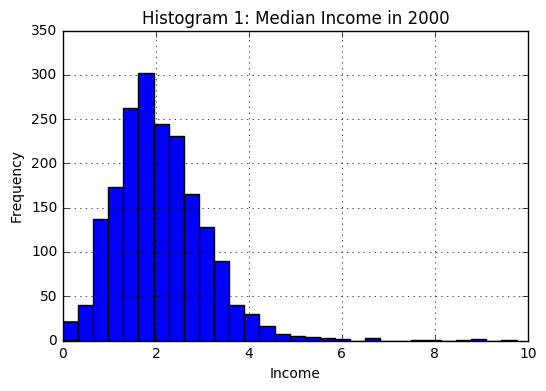

In [172]:
Y2000_hist = merge_00['Median_Income'].hist(bins = 30)
Y2000_hist.set_title("Histogram 1: Median Income in 2000")
Y2000_hist.set_xlabel("Income")
Y2000_hist.set_ylabel("Frequency")
#plt.text(1880, -30000, 'Age distribution for all CitiBike Users.', fontsize = 12 )

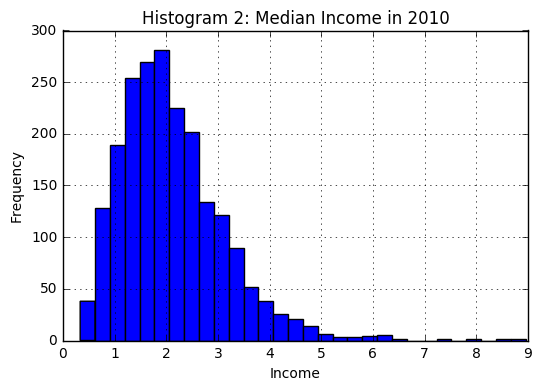

In [173]:
Y2010_hist = merge_10['Median_Income'].hist(bins = 30)
Y2010_hist.set_title("Histogram 2: Median Income in 2010")
Y2010_hist.set_xlabel("Income")
Y2010_hist.set_ylabel("Frequency")
#plt.text(1880, -30000, 'Age distribution for all CitiBike Users.', fontsize = 12 )

The plots above show that the median income has increased from 2000 to 2010.

In [ ]:
#merge_10.type

Merge the df with the census tracts shapefile (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choropleth.

In [76]:
merged_sf_ct00 = pd.merge(census_tract,merge_00, on = 'geo_id', how = 'inner')
merged_sf_ct00.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3027500  Brooklyn        1261          I  027500     275   
1         2      2009200     Bronx        1294          E  009200      92   
2         4      4099100    Queens        1306          I  099100     991   
3         4      4000100    Queens        1407          I  000100       1   
4         3      3024100  Brooklyn        1425          E  024100     241   

                                          geometry_x ntacode  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...    BK75   

                                ntaname  puma     shape_area     shape_leng  \
0                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
1                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
2                            Whitestone  4103  11557974.9909  17092.0365078   
3  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   
4                               Bedford  4003  1939949.84007  5837.00532323   

                codes                geo_id  \
0  (Brooklyn, 027500)  1400000US36047027500   
1     (Bronx, 009200)  1400000US36005009200   
2    (Queens, 099100)  1400000US36081099100   
3    (Queens, 000100)  1400000US36081000100   
4  (Brooklyn, 024100)  1400000US36047024100   

                                          geometry_y  Total_pop  Age_median  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...       4171        33.9   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...       4877        31.7   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...       6659        47.1   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...       1370        41.3   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...       1564        36.2   

   White_Pop(%)  Median_Income  
0           1.5          30241  
1          30.1          36589  
2          87.7          62341  
3          55.4          85898  
4          10.4          10500

In [77]:
merged_sf_ct00 = merged_sf_ct00.drop(['geometry_y'], axis = 1)
merged_sf_ct00.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3027500  Brooklyn        1261          I  027500     275   
1         2      2009200     Bronx        1294          E  009200      92   
2         4      4099100    Queens        1306          I  099100     991   
3         4      4000100    Queens        1407          I  000100       1   
4         3      3024100  Brooklyn        1425          E  024100     241   

                                          geometry_x ntacode  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...    BK75   

                                ntaname  puma     shape_area     shape_leng  \
0                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
1                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
2                            Whitestone  4103  11557974.9909  17092.0365078   
3  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   
4                               Bedford  4003  1939949.84007  5837.00532323   

                codes                geo_id  Total_pop  Age_median  \
0  (Brooklyn, 027500)  1400000US36047027500       4171        33.9   
1     (Bronx, 009200)  1400000US36005009200       4877        31.7   
2    (Queens, 099100)  1400000US36081099100       6659        47.1   
3    (Queens, 000100)  1400000US36081000100       1370        41.3   
4  (Brooklyn, 024100)  1400000US36047024100       1564        36.2   

   White_Pop(%)  Median_Income  
0           1.5          30241  
1          30.1          36589  
2          87.7          62341  
3          55.4          85898  
4          10.4          10500

In [78]:
merged_sf_ct00 = merged_sf_ct00.rename(columns = {"geometry_x":"geometry"})
merged_sf_ct00.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3027500  Brooklyn        1261          I  027500     275   
1         2      2009200     Bronx        1294          E  009200      92   
2         4      4099100    Queens        1306          I  099100     991   
3         4      4000100    Queens        1407          I  000100       1   
4         3      3024100  Brooklyn        1425          E  024100     241   

                                            geometry ntacode  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...    BK75   

                                ntaname  puma     shape_area     shape_leng  \
0                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
1                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
2                            Whitestone  4103  11557974.9909  17092.0365078   
3  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   
4                               Bedford  4003  1939949.84007  5837.00532323   

                codes                geo_id  Total_pop  Age_median  \
0  (Brooklyn, 027500)  1400000US36047027500       4171        33.9   
1     (Bronx, 009200)  1400000US36005009200       4877        31.7   
2    (Queens, 099100)  1400000US36081099100       6659        47.1   
3    (Queens, 000100)  1400000US36081000100       1370        41.3   
4  (Brooklyn, 024100)  1400000US36047024100       1564        36.2   

   White_Pop(%)  Median_Income  
0           1.5          30241  
1          30.1          36589  
2          87.7          62341  
3          55.4          85898  
4          10.4          10500

In [79]:
merged_sf_ct10 = pd.merge(census_tract,merge_10, on = 'geo_id', how = 'inner')
merged_sf_ct10.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                          geometry_x ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

                codes                geo_id  \
0  (Brooklyn, 050804)  1400000US36047050804   
1  (Brooklyn, 027500)  1400000US36047027500   
2     (Bronx, 009200)  1400000US36005009200   
3    (Queens, 099100)  1400000US36081099100   
4    (Queens, 000100)  1400000US36081000100   

                                          geometry_y  Total_pop  Age_median  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...       6250        32.7   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...       4180        35.6   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...       5017        33.3   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...       6507        51.1   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...       4949        32.4   

   White_Pop(%)  Median_Income  
0          15.5        40188.0  
1           9.1        52958.0  
2          29.5        45625.0  
3          85.5        84350.0  
4          63.5       117750.0

In [80]:
merged_sf_ct10.columns

Index([    u'boro_code',  u'boro_ct_2010',     u'boro_name',    u'cartodb_id',
          u'cdeligibil',       u'ct_2010',       u'ctlabel',    u'geometry_x',
             u'ntacode',       u'ntaname',          u'puma',    u'shape_area',
          u'shape_leng',         u'codes',        u'geo_id',    u'geometry_y',
           u'Total_pop',    u'Age_median',  u'White_Pop(%)', u'Median_Income'],
      dtype='object')

In [81]:
merged_sf_ct10 = merged_sf_ct10.drop(['geometry_y'], axis = 1)
merged_sf_ct10.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                          geometry_x ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

                codes                geo_id  Total_pop  Age_median  \
0  (Brooklyn, 050804)  1400000US36047050804       6250        32.7   
1  (Brooklyn, 027500)  1400000US36047027500       4180        35.6   
2     (Bronx, 009200)  1400000US36005009200       5017        33.3   
3    (Queens, 099100)  1400000US36081099100       6507        51.1   
4    (Queens, 000100)  1400000US36081000100       4949        32.4   

   White_Pop(%)  Median_Income  
0          15.5        40188.0  
1           9.1        52958.0  
2          29.5        45625.0  
3          85.5        84350.0  
4          63.5       117750.0

In [82]:
merged_sf_ct10 = merged_sf_ct10.rename(columns = {"geometry_x":"geometry"})
merged_sf_ct10.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

                codes                geo_id  Total_pop  Age_median  \
0  (Brooklyn, 050804)  1400000US36047050804       6250        32.7   
1  (Brooklyn, 027500)  1400000US36047027500       4180        35.6   
2     (Bronx, 009200)  1400000US36005009200       5017        33.3   
3    (Queens, 099100)  1400000US36081099100       6507        51.1   
4    (Queens, 000100)  1400000US36081000100       4949        32.4   

   White_Pop(%)  Median_Income  
0          15.5        40188.0  
1           9.1        52958.0  
2          29.5        45625.0  
3          85.5        84350.0  
4          63.5       117750.0

Choropleths for everything: 

In [83]:
medianincome00 = psl.Quantiles(merged_sf_ct00['Median_Income'], k = 6)
medianincome00

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=  22850.667               322
 22850.667 < x[i] <=  31110.000               321
 31110.000 < x[i] <=  37895.000               322
 37895.000 < x[i] <=  46250.000               322
 46250.000 < x[i] <=  57164.000               320
 57164.000 < x[i] <= 188697.000               322

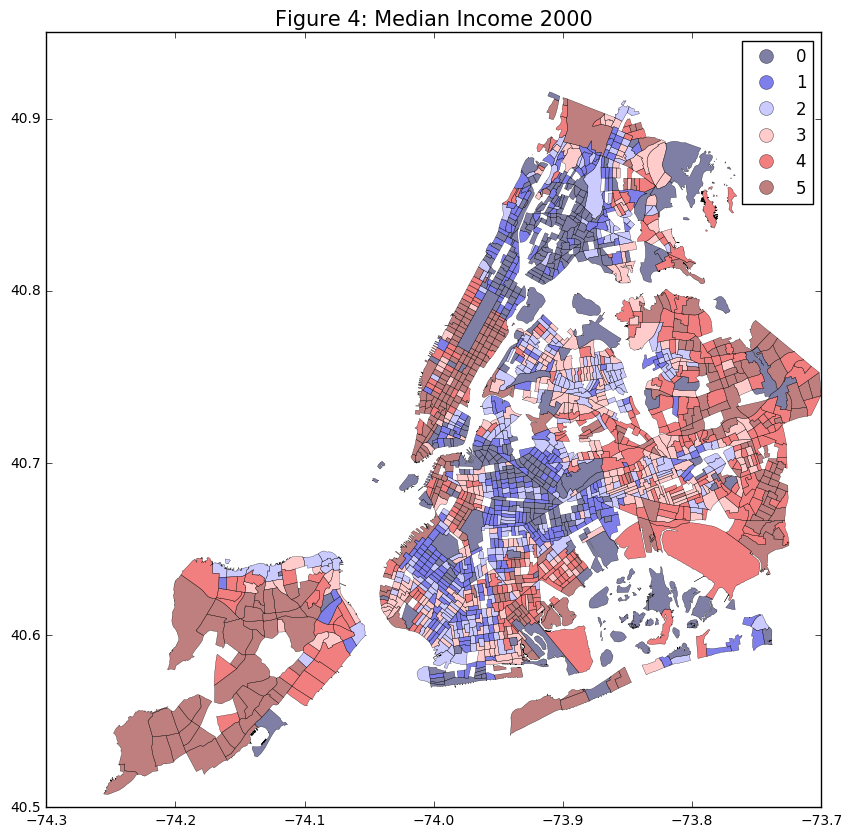

In [84]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merged_sf_ct00.assign(cl=medianincome00.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure 4: Median Income 2000", fontsize = '15')

In [85]:
medianincome10 = psl.Quantiles(merged_sf_ct10['Median_Income'], k = 6)
medianincome10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <= 31519.333               722
31519.333 < x[i] <= 41443.333               361
41443.333 < x[i] <= 51677.500               361
51677.500 < x[i] <= 62656.000               362
62656.000 < x[i] <= 81323.167               360
81323.167 < x[i] <=       nan                 0

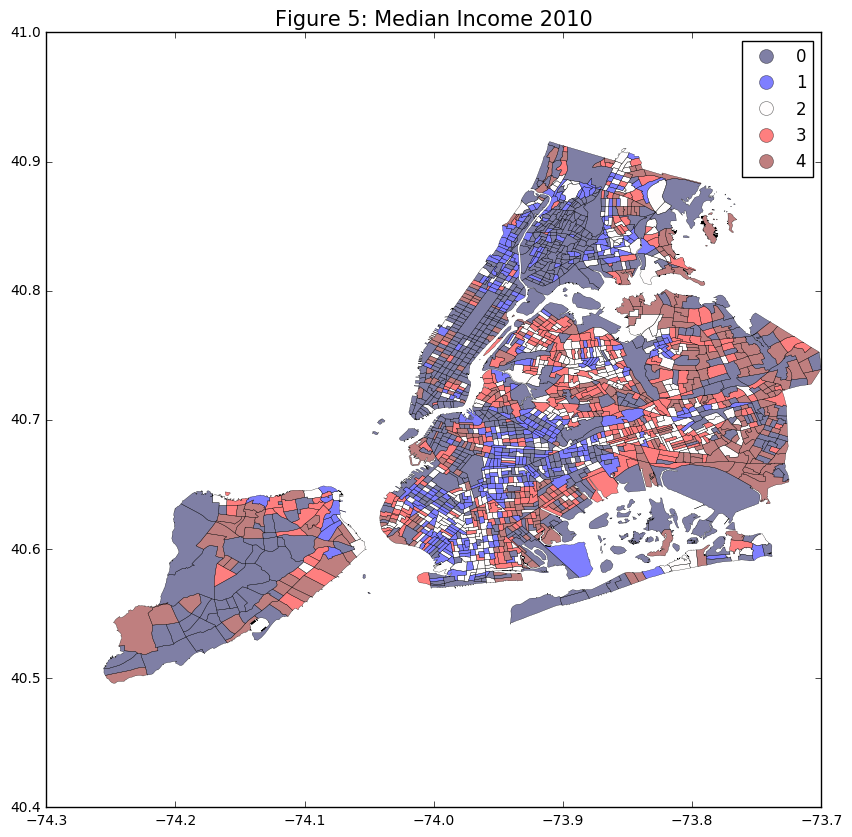

In [86]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merged_sf_ct10.assign(cl=medianincome10.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure 5: Median Income 2010", fontsize = '15')

In [193]:
tot_pop00 = psl.Quantiles(merged_sf_ct00['Total_pop'], k = 6)
tot_pop00


                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=  1771.667               322
 1771.667 < x[i] <=  2528.667               321
 2528.667 < x[i] <=  3281.000               322
 3281.000 < x[i] <=  4065.000               321
 4065.000 < x[i] <=  5458.000               321
 5458.000 < x[i] <= 24523.000               322

In [194]:
tot_pop10 = psl.Quantiles(merged_sf_ct10['Total_pop'], k = 6)
tot_pop10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=  1895.667               361
 1895.667 < x[i] <=  2646.333               361
 2646.333 < x[i] <=  3426.500               361
 3426.500 < x[i] <=  4241.000               362
 4241.000 < x[i] <=  5598.333               360
 5598.333 < x[i] <= 26588.000               361

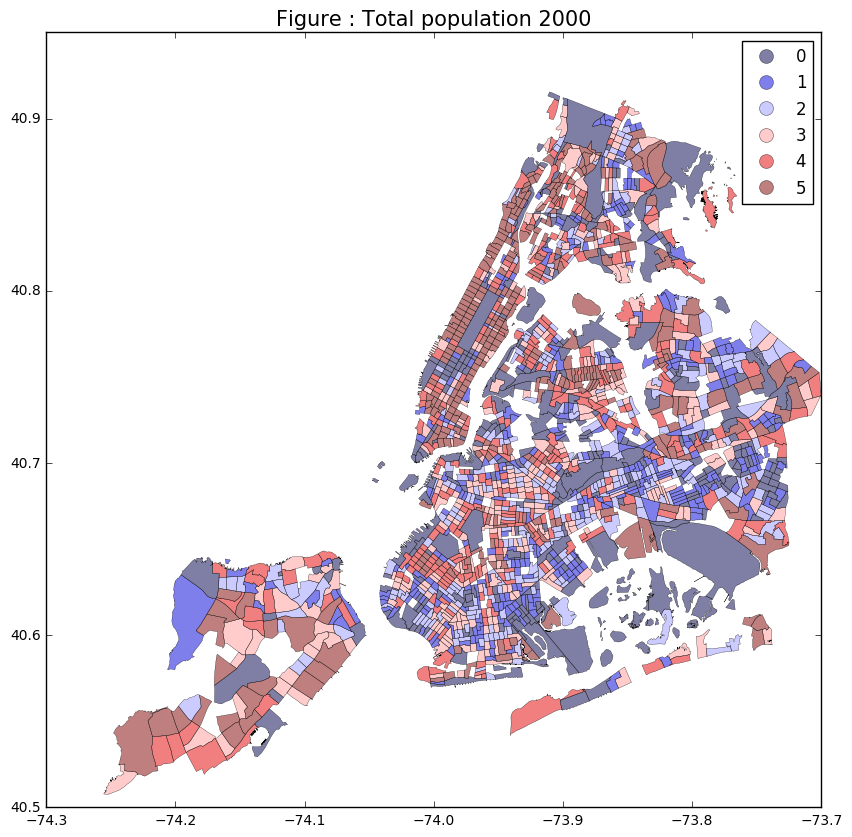

In [200]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merged_sf_ct00.assign(cl=tot_pop00.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : Total population 2000", fontsize = '15')

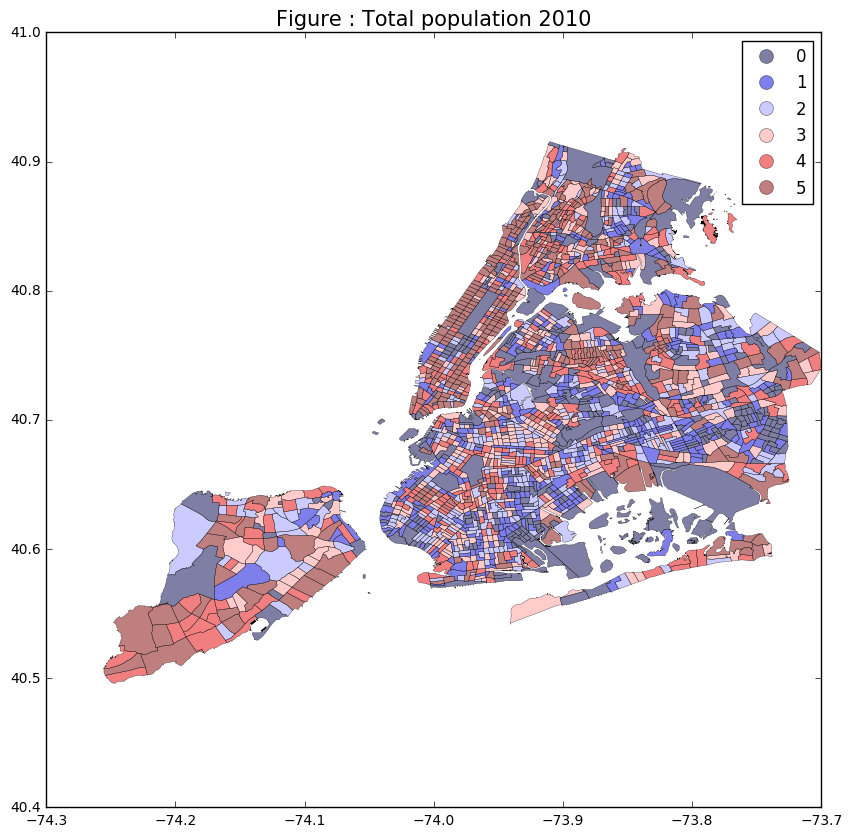

In [201]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merged_sf_ct10.assign(cl=tot_pop10.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : Total population 2010", fontsize = '15')

In [196]:
med_age00 = psl.Quantiles(merged_sf_ct00['Age_median'], k = 6)
med_age00

                Quantiles                
 
Lower            Upper              Count
         x[i] <= 28.900               329
28.900 < x[i] <= 32.000               324
32.000 < x[i] <= 34.100               319
34.100 < x[i] <= 36.300               320
36.300 < x[i] <= 39.200               322
39.200 < x[i] <= 75.800               315

In [197]:
med_age10 = psl.Quantiles(merged_sf_ct10['Age_median'], k = 6)
med_age10

                Quantiles                
 
Lower            Upper              Count
         x[i] <= 30.500               366
30.500 < x[i] <= 33.200               361
33.200 < x[i] <= 35.500               357
35.500 < x[i] <= 37.900               364
37.900 < x[i] <= 41.600               359
41.600 < x[i] <= 84.500               359

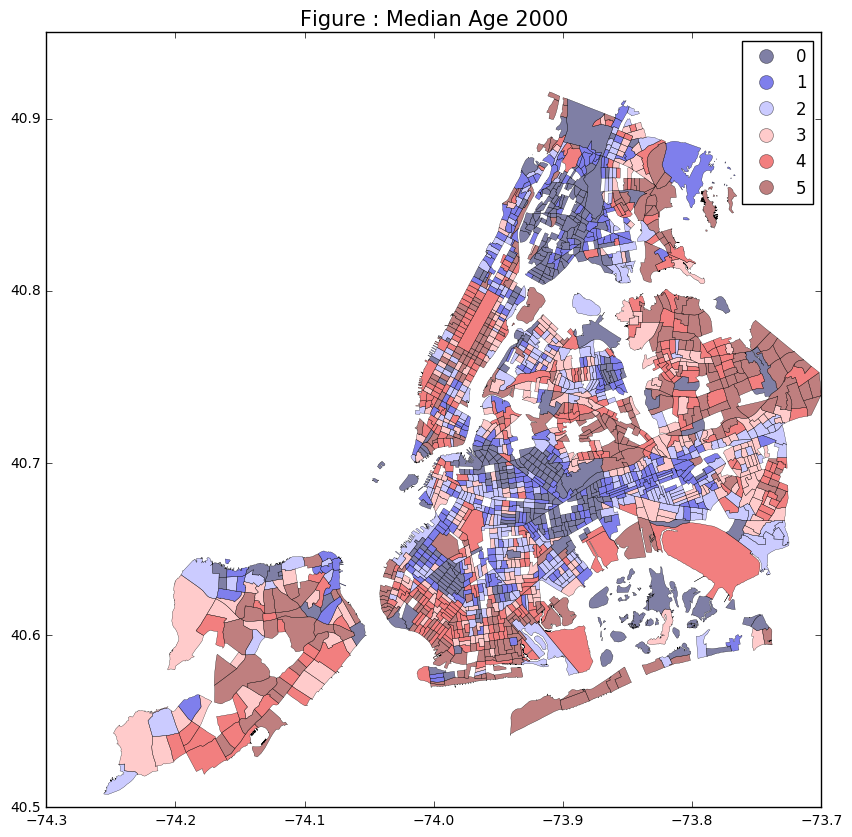

In [202]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merged_sf_ct00.assign(cl=med_age00.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : Median Age 2000", fontsize = '15')

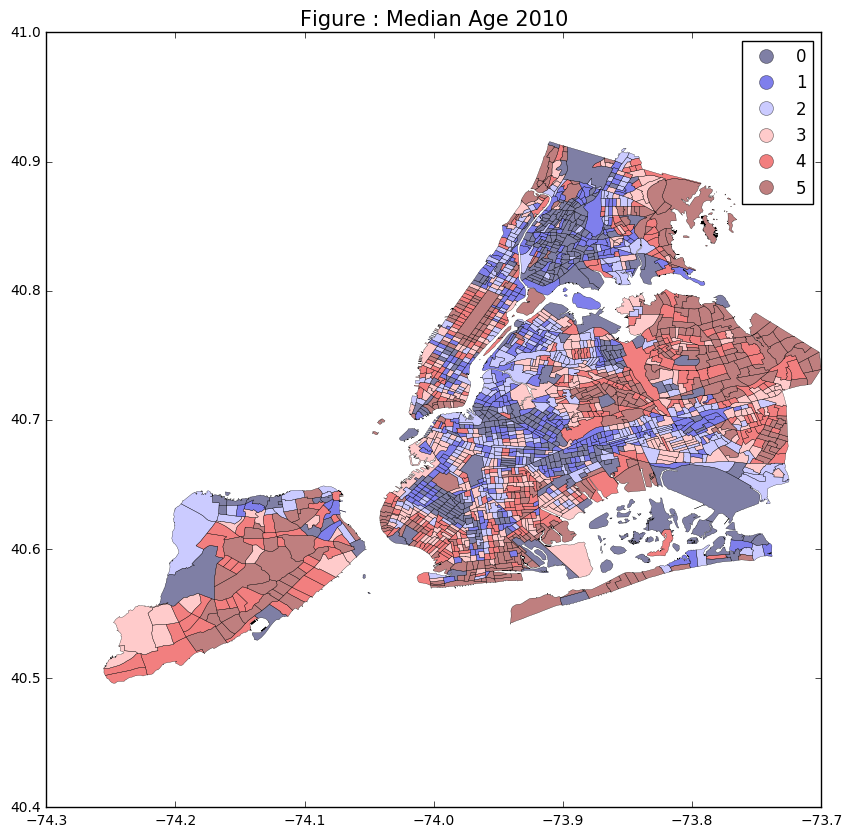

In [204]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merged_sf_ct10.assign(cl=med_age10.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : Median Age 2010", fontsize = '15')

In [198]:
whitepop00 = psl.Quantiles(merged_sf_ct00['White_Pop(%)'], k = 6)
whitepop00

                Quantiles                
 
Lower            Upper              Count
         x[i] <=  9.700               643
 9.700 < x[i] <= 23.800               321
23.800 < x[i] <= 43.000               321
43.000 < x[i] <= 66.233               321
66.233 < x[i] <= 82.400               323
82.400 < x[i] <=    nan                 0

In [199]:
whitepop10 = psl.Quantiles(merged_sf_ct10['White_Pop(%)'], k = 6)
whitepop10

                Quantiles                
 
Lower            Upper              Count
         x[i] <= 11.000               723
11.000 < x[i] <= 23.900               361
23.900 < x[i] <= 41.000               362
41.000 < x[i] <= 62.300               359
62.300 < x[i] <= 79.900               361
79.900 < x[i] <=    nan                 0

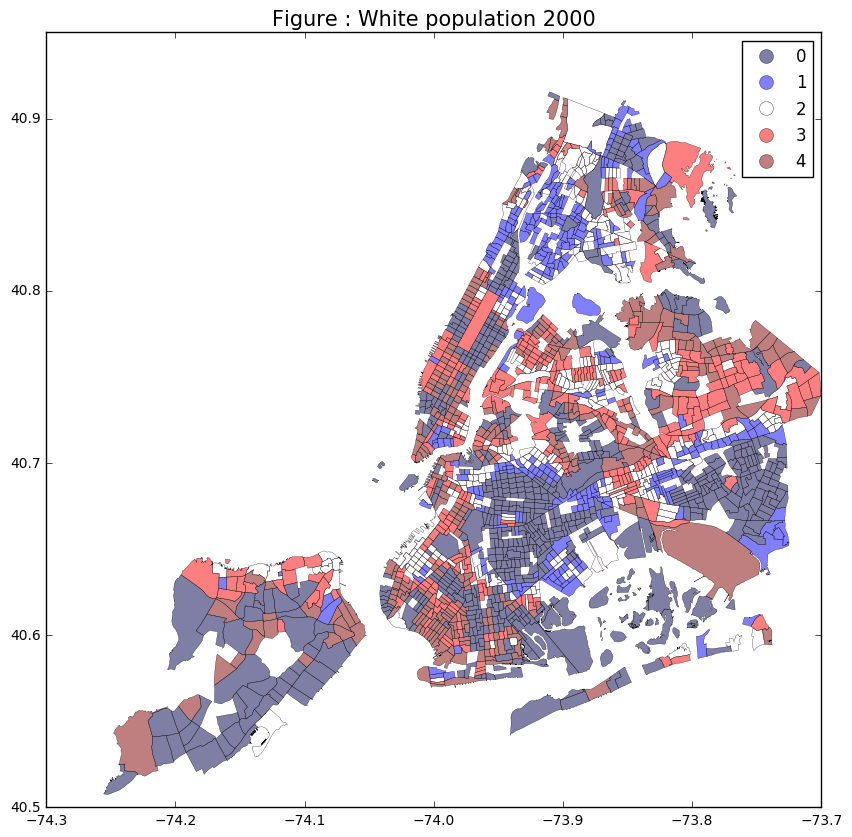

In [205]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merged_sf_ct00.assign(cl=whitepop00.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : White population 2000", fontsize = '15')

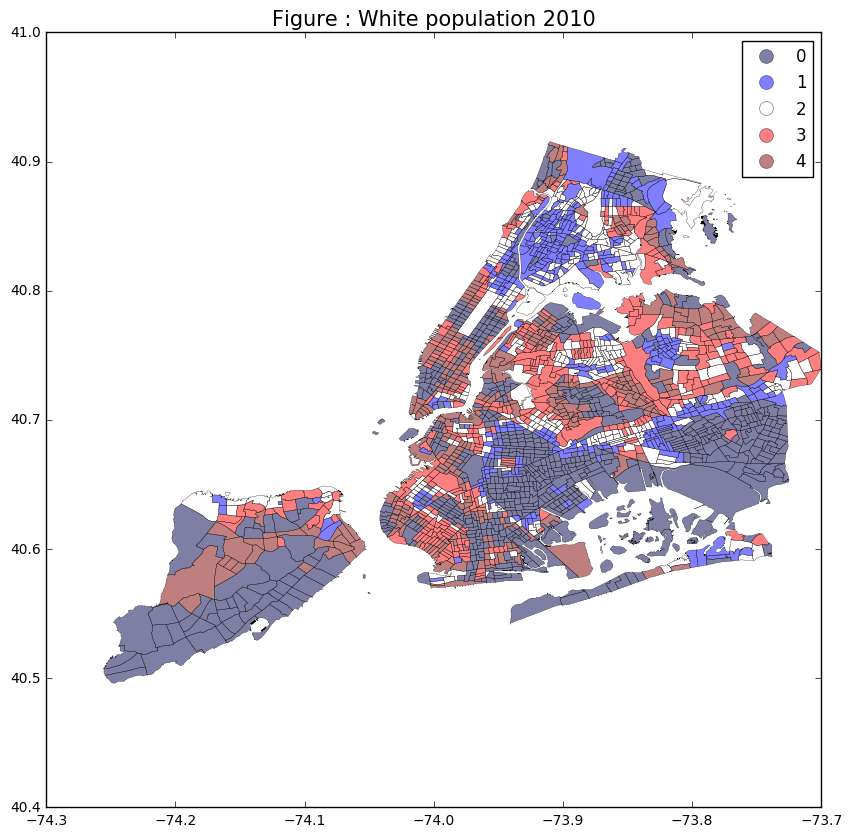

In [203]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merged_sf_ct10.assign(cl=whitepop10.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : White population 2010", fontsize = '15')

Differences in the features:
Adding a new column in the 2010 data to add the differences in the dataframe

In [176]:
merged_sf_ct10['diff_pop'] = merged_sf_ct10['Total_pop'] - merged_sf_ct00['Total_pop']
merged_sf_ct10['diff_median_age'] = merged_sf_ct10['Age_median'] - merged_sf_ct00['Age_median']
merged_sf_ct10['diff_white_pop'] = merged_sf_ct10['White_Pop(%)'] - merged_sf_ct00['White_Pop(%)']
merged_sf_ct10['diff_median_income'] = merged_sf_ct10['Median_Income'] - merged_sf_ct00['Median_Income']
merged_sf_ct10.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname         ...          \
0                              Flatbush         ...           
1                    Stuyvesant Heights         ...           
2                 Westchester-Unionport         ...           
3                            Whitestone         ...           
4  Hunters Point-Sunnyside-West Maspeth         ...           

                codes                geo_id Total_pop Age_median White_Pop(%)  \
0  (Brooklyn, 050804)  1400000US36047050804      6250       32.7         15.5   
1  (Brooklyn, 027500)  1400000US36047027500      4180       35.6          9.1   
2     (Bronx, 009200)  1400000US36005009200      5017       33.3         29.5   
3    (Queens, 099100)  1400000US36081099100      6507       51.1         85.5   
4    (Queens, 000100)  1400000US36081000100      4949       32.4         63.5   

   Median_Income  diff_pop  diff_median_age  diff_white_pop  \
0        40188.0    2079.0             -1.2            14.0   
1        52958.0    -697.0              3.9           -21.0   
2        45625.0   -1642.0            -13.8           -58.2   
3        84350.0    5137.0              9.8            30.1   
4       117750.0    3385.0             -3.8            53.1   

   diff_median_income  
0              9947.0  
1             16369.0  
2            -16716.0  
3             -1548.0  
4            107250.0  

[5 rows x 23 columns]

In [181]:
diff_pop = psl.Quantiles(merged_sf_ct10['diff_pop'], k = 6)
diff_pop

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <= -2280.500               722
-2280.500 < x[i] <=  -674.667               361
 -674.667 < x[i] <=   452.000               362
  452.000 < x[i] <=  1803.333               360
 1803.333 < x[i] <=  4398.833               361
 4398.833 < x[i] <=       nan                 0

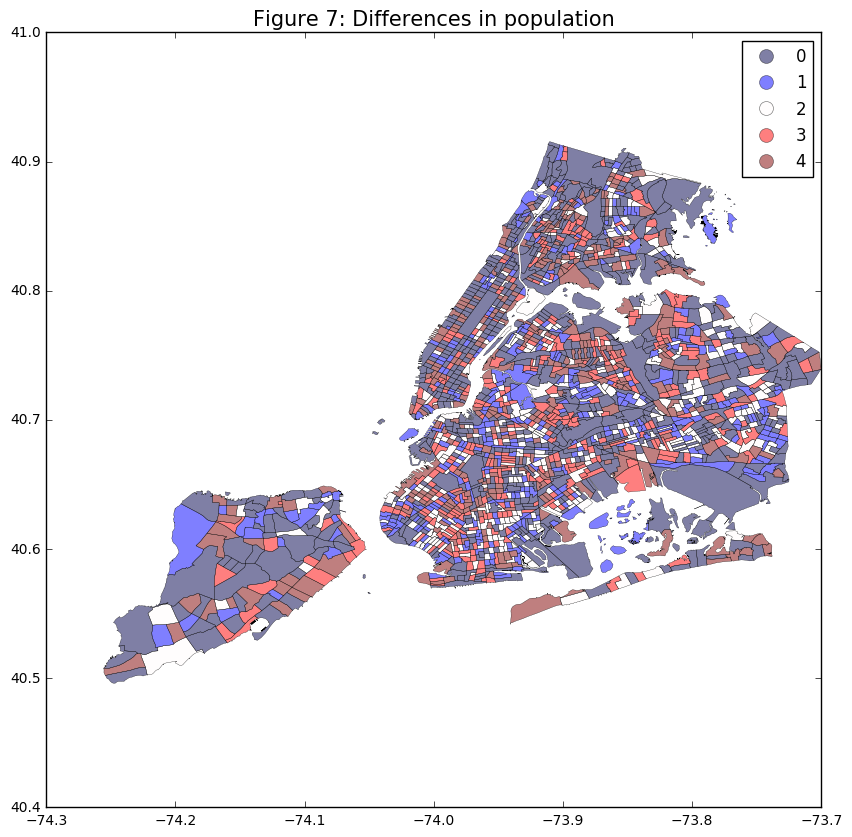

In [186]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

merged_sf_ct10.assign(cl=diff_pop.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure 7: Differences in population", fontsize = '15')

In [184]:
diff_med_age = psl.Quantiles(merged_sf_ct10['diff_median_age'], k = 6)
diff_med_age

                Quantiles                
 
Lower            Upper              Count
         x[i] <= -5.300               723
-5.300 < x[i] <= -1.000               361
-1.000 < x[i] <=  3.000               369
 3.000 < x[i] <=  7.200               356
 7.200 < x[i] <= 14.200               357
14.200 < x[i] <=    nan                 0

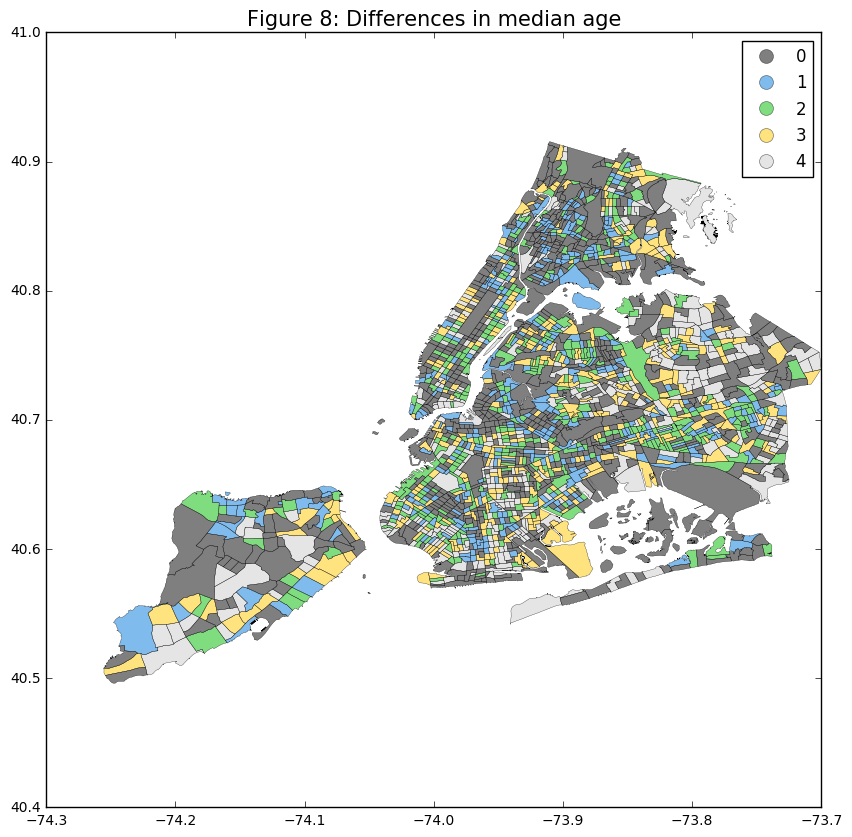

In [187]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

merged_sf_ct10.assign(cl=diff_med_age.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='spectral',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure 8: Differences in median age", fontsize = '15')

In [188]:
diff_whitepop = psl.Quantiles(merged_sf_ct10['diff_white_pop'], k = 6)
diff_whitepop

                 Quantiles                 
 
 Lower            Upper               Count
          x[i] <= -41.033               722
-41.033 < x[i] <= -13.833               361
-13.833 < x[i] <=   4.900               361
  4.900 < x[i] <=  28.400               361
 28.400 < x[i] <=  76.217               361
 76.217 < x[i] <=     nan                 0

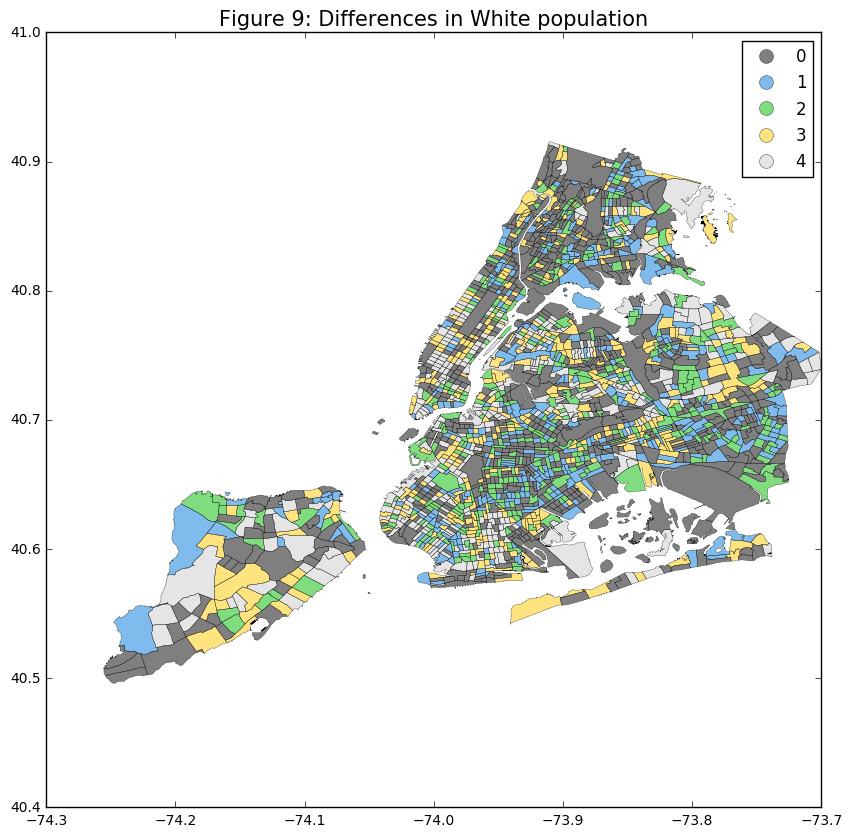

In [190]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

merged_sf_ct10.assign(cl=diff_whitepop.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='spectral',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure 9: Differences in White population", fontsize = '15')

In [191]:
diff_med_income = psl.Quantiles(merged_sf_ct10['Median_Income'], k = 6)
diff_med_income

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <= 31519.333               722
31519.333 < x[i] <= 41443.333               361
41443.333 < x[i] <= 51677.500               361
51677.500 < x[i] <= 62656.000               362
62656.000 < x[i] <= 81323.167               360
81323.167 < x[i] <=       nan                 0

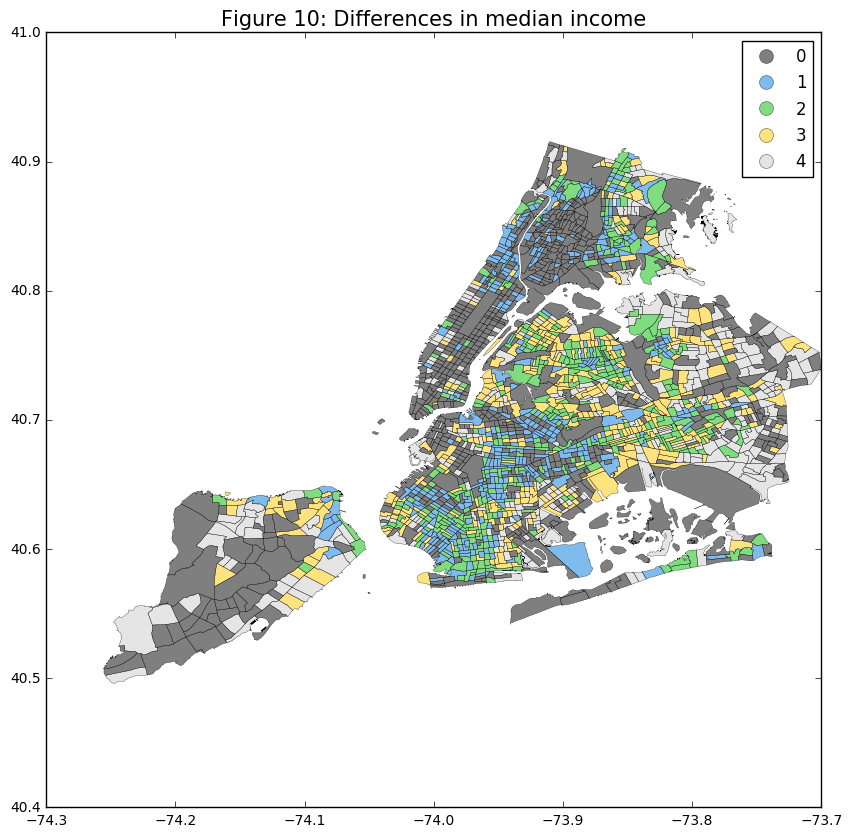

In [192]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

merged_sf_ct10.assign(cl=diff_med_income.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='spectral',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure 10: Differences in median income", fontsize = '15')

In [88]:
merge_00.head()

geometry                geo_id  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_pop  Age_median  White_Pop(%)  Median_Income  
0       4171        33.9           1.5          30241  
1       4877        31.7          30.1          36589  
2       6659        47.1          87.7          62341  
3       1370        41.3          55.4          85898  
4       1564        36.2          10.4          10500

Whitening the data:

In [111]:
merge_00 = merge_00.dropna()

In [112]:
merge_00['Total_pop'] = merge_00['Total_pop']/merge_00['Total_pop'].std()
merge_00['Median_Income'] = merge_00['Median_Income']/merge_00['Median_Income'].std()
merge_00['White_Pop(%)'] = merge_00['White_Pop(%)']/merge_00['White_Pop(%)'].std()
merge_00['Age_median'] = merge_00['Age_median']/merge_00['Age_median'].std()

In [113]:
merge_00.head()

geometry                geo_id  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_pop  Age_median  White_Pop(%)  Median_Income  Cluster_center  
0   1.896306    5.745077      0.048538       1.563463               4  
1   2.217282    5.372240      0.974004       1.891656               4  
2   3.027452    7.982098      2.837878       3.223037               2  
3   0.622858    6.999165      1.792685       4.440937               5  
4   0.711058    6.134861      0.336533       0.542851               4

In [114]:
km_00 = ['Total_pop','Age_median','White_Pop(%)','Median_Income'] 

In [115]:
kmeans_00 = KMeans(n_clusters=6, random_state=444)

In [116]:
kmeans_00.fit(merge_00[km_00])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=444, tol=0.0001,
    verbose=0)

In [95]:
kmeans_00.labels_

array([4, 4, 2, ..., 3, 4, 3], dtype=int32)

In [96]:
merge_00['Cluster_center'] = kmeans_00.labels_
merge_00.head()

geometry                geo_id  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_pop  Age_median  White_Pop(%)  Median_Income  Cluster_center  
0   1.879572    4.996914      0.048538       1.538131               4  
1   2.197715    4.672631      0.974004       1.861006               4  
2   3.000735    6.942616      2.837878       3.170816               2  
3   0.617361    6.087686      1.792685       4.368983               5  
4   0.704783    5.335938      0.336533       0.534056               4

In [131]:
len (merge_00)

1910

In [132]:
len (merge_00['Cluster_center'])

1910

In [117]:
merge_10 = merge_10.dropna()

In [118]:
merge_10['Total_pop'] = merge_10['Total_pop']/merge_10['Total_pop'].std()
merge_10['Median_Income'] = merge_10['Median_Income']/merge_10['Median_Income'].std()
merge_10['White_Pop(%)'] = merge_10['White_Pop(%)']/merge_10['White_Pop(%)'].std()
merge_10['Age_median'] = merge_10['Age_median']/merge_10['Age_median'].std()

In [119]:
merge_10 = merge_10.dropna()
merge_10.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_pop  Age_median  White_Pop(%)  Median_Income  Cluster_center  
0   2.956435    5.435668      0.526868       1.546387               0  
1   1.977264    5.917731      0.309323       2.037761               1  
2   2.373189    5.535405      1.002749       1.755596               4  
3   3.078003    8.494271      2.906272       3.245688               2  
4   2.341023    5.385800      2.158459       4.530880               2

In [120]:
km_10 = ['Total_pop','Age_median','White_Pop(%)','Median_Income']

In [121]:
kmeans_10 = KMeans(n_clusters=6, init = kmeans_00.cluster_centers_, random_state=444)

In [122]:
kmeans_10.fit(merge_10[km_10])

KMeans(copy_x=True,
    init=array([[ 1.58459,  4.87305,  0.65215,  1.20265],
       [ 1.15213,  7.17137,  2.55861,  2.64635],
       [ 1.39727,  5.75426,  2.12435,  2.0507 ],
       [ 2.82369,  6.49224,  2.71955,  3.82473],
       [ 1.15991,  5.8644 ,  0.52159,  2.3458 ],
       [ 3.46662,  5.41193,  0.89966,  1.44987]]),
    max_iter=300, n_clusters=6, n_init=10, n_jobs=1,
    precompute_distances='auto', random_state=444, tol=0.0001, verbose=0)

In [123]:
merge_10['Cluster_center'] = kmeans_10.labels_
merge_10.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_pop  Age_median  White_Pop(%)  Median_Income  Cluster_center  
0   2.956435    5.435668      0.526868       1.546387               5  
1   1.977264    5.917731      0.309323       2.037761               4  
2   2.373189    5.535405      1.002749       1.755596               0  
3   3.078003    8.494271      2.906272       3.245688               1  
4   2.341023    5.385800      2.158459       4.530880               3

In [124]:
merge_cluster = pd.merge(merge_00, merge_10, on = 'geo_id')
merge_cluster.head()

geometry_x                geo_id  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Total_pop_x  Age_median_x  White_Pop(%)_x  Median_Income_x  \
0     1.896306      5.745077        0.048538         1.563463   
1     2.217282      5.372240        0.974004         1.891656   
2     3.027452      7.982098        2.837878         3.223037   
3     0.622858      6.999165        1.792685         4.440937   
4     0.711058      6.134861        0.336533         0.542851   

   Cluster_center_x                                         geometry_y  \
0                 4  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
1                 4  (POLYGON ((-73.847279 40.829315, -73.847320999...   
2                 2  (POLYGON ((-73.791793 40.789352, -73.791563999...   
3                 5  (POLYGON ((-73.949113 40.754524, -73.949144 40...   
4                 4  (POLYGON ((-73.951465 40.689863, -73.955122 40...   

   Total_pop_y  Age_median_y  White_Pop(%)_y  Median_Income_y  \
0     1.977264      5.917731        0.309323         2.037761   
1     2.373189      5.535405        1.002749         1.755596   
2     3.078003      8.494271        2.906272         3.245688   
3     2.341023      5.385800        2.158459         4.530880   
4     1.054383      5.202949        1.485428         1.533804   

   Cluster_center_y  
0                 4  
1                 0  
2                 1  
3                 3  
4                 0

In [125]:
merge_cluster.columns

Index([u'geometry_x', u'geo_id', u'Total_pop_x', u'Age_median_x',
       u'White_Pop(%)_x', u'Median_Income_x', u'Cluster_center_x',
       u'geometry_y', u'Total_pop_y', u'Age_median_y', u'White_Pop(%)_y',
       u'Median_Income_y', u'Cluster_center_y'],
      dtype='object')

In [126]:
merge_cluster = merge_cluster.drop(['geometry_y'], axis = 1)

In [127]:
merge_cluster = merge_cluster.rename(columns = {'geometry_x':'geometry','Total_pop_x':'Tot_pop_2000',
                                                'Age_median_x':'Age_median_2000','White_Pop(%)_x':'white_pop(%)2000',
                                                'Median_Income_x':'Median_Income_2000','Total_pop_y':'Total_pop_2010',
                                                'Age_median_y':'Age_median_2010','White_Pop(%)_y':'White_Pop(%)_2010',
                                                'Median_Income_y':'Median_Income_2010'})

In [128]:
merge_cluster.head()

geometry                geo_id  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...  1400000US36047024100   

   Tot_pop_2000  Age_median_2000  white_pop(%)2000  Median_Income_2000  \
0      1.896306         5.745077          0.048538            1.563463   
1      2.217282         5.372240          0.974004            1.891656   
2      3.027452         7.982098          2.837878            3.223037   
3      0.622858         6.999165          1.792685            4.440937   
4      0.711058         6.134861          0.336533            0.542851   

   Cluster_center_x  Total_pop_2010  Age_median_2010  White_Pop(%)_2010  \
0                 4        1.977264         5.917731           0.309323   
1                 4        2.373189         5.535405           1.002749   
2                 2        3.078003         8.494271           2.906272   
3                 5        2.341023         5.385800           2.158459   
4                 4        1.054383         5.202949           1.485428   

   Median_Income_2010  Cluster_center_y  
0            2.037761                 4  
1            1.755596                 0  
2            3.245688                 1  
3            4.530880                 3  
4            1.533804                 0

In [133]:
cluster_00 = psl.Quantiles(merge_00['Cluster_center'], k = 6)
cluster_00

               Quantiles               
 
Lower          Upper              Count
        x[i] <= 1.000               577
1.000 < x[i] <= 2.000               155
2.000 < x[i] <= 3.000               420
3.000 < x[i] <= 4.000               445
4.000 < x[i] <= 5.000               313

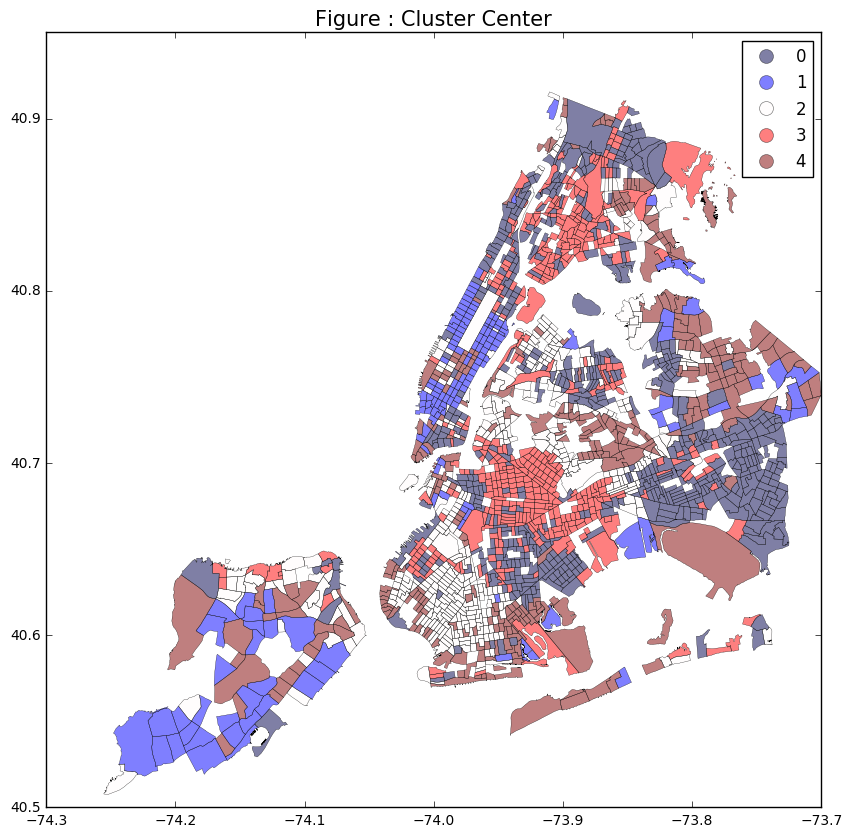

In [206]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merge_00.assign(cl=cluster_00.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : Cluster Center", fontsize = '15')

In [135]:
cluster_10 = psl.Quantiles(merge_10['Cluster_center'], k = 6)
cluster_10

               Quantiles               
 
Lower          Upper              Count
        x[i] <= 0.000               505
0.000 < x[i] <= 1.000               309
1.000 < x[i] <= 2.000               492
2.000 < x[i] <= 3.000               175
3.000 < x[i] <= 4.000               392
4.000 < x[i] <= 5.000               236

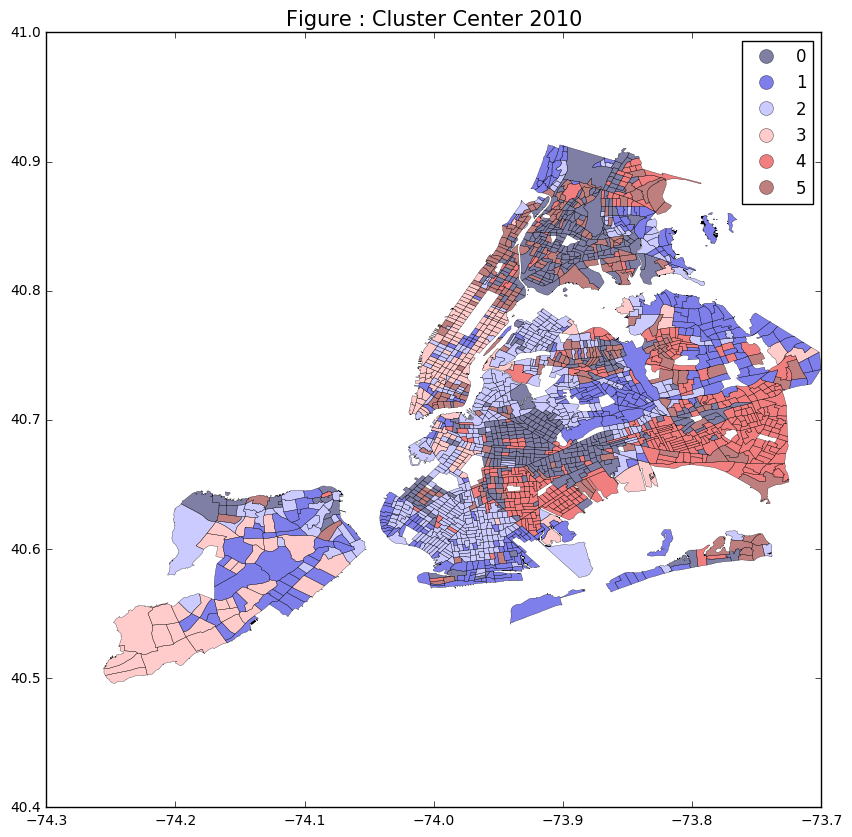

In [207]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merge_10.assign(cl=cluster_10.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='seismic',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : Cluster Center 2010", fontsize = '15')

In [209]:
merge_10['Cluster_center_diff'] = merge_10['Cluster_center'] - merge_00['Cluster_center']
merge_10.head()

geometry                geo_id  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...  1400000US36047050804   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...  1400000US36047027500   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...  1400000US36005009200   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...  1400000US36081099100   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...  1400000US36081000100   

   Total_pop  Age_median  White_Pop(%)  Median_Income  Cluster_center  \
0   2.956435    5.435668      0.526868       1.546387               5   
1   1.977264    5.917731      0.309323       2.037761               4   
2   2.373189    5.535405      1.002749       1.755596               0   
3   3.078003    8.494271      2.906272       3.245688               1   
4   2.341023    5.385800      2.158459       4.530880               3   

   Cluster_center_diff  
0                  1.0  
1                  0.0  
2                 -2.0  
3                 -4.0  
4                 -1.0

In [211]:
cluster_diff = psl.Quantiles(merge_10['Cluster_center_diff'], k = 6)
cluster_diff

                Quantiles                
 
Lower            Upper              Count
         x[i] <= -3.000               788
-3.000 < x[i] <= -1.000               525
-1.000 < x[i] <=  0.000               286
 0.000 < x[i] <=  1.000               250
 1.000 < x[i] <=  3.000               260
 3.000 < x[i] <=    nan                 0

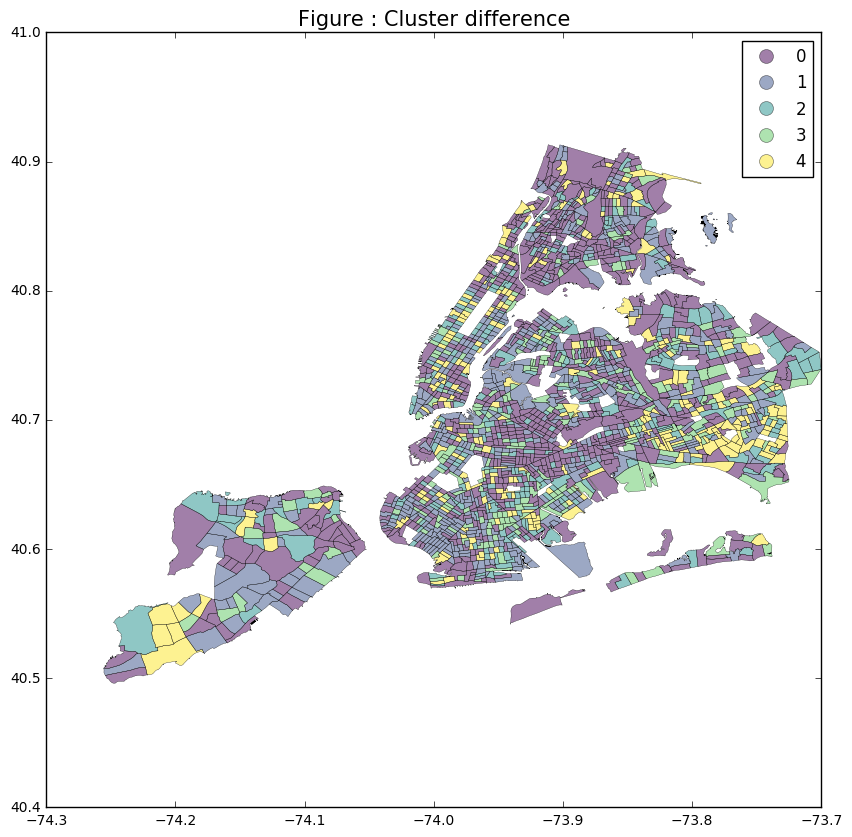

In [235]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
merge_10.assign(cl=cluster_diff.yb).plot(column='cl', categorical=True, 
                                            k=6, cmap='viridis',ax=ax, linewidth=0.2, edgecolor='black', legend=True)
ax.set_title("Figure : Cluster difference", fontsize = '15')

In [218]:
merged_sf_ctnew = pd.merge(merged_sf_ct10, merged_sf_ct00, on = 'geo_id', how = 'inner')

In [219]:
merged_sf_ctnew.head()

boro_code_x boro_ct_2010_x boro_name_x  cartodb_id_x cdeligibil_x ct_2010_x  \
0           3        3027500    Brooklyn          1261            I    027500   
1           2        2009200       Bronx          1294            E    009200   
2           4        4099100      Queens          1306            I    099100   
3           4        4000100      Queens          1407            I    000100   
4           3        3024100    Brooklyn          1425            E    024100   

  ctlabel_x                                         geometry_x ntacode_x  \
0       275  (POLYGON ((-73.935008 40.682764, -73.937932 40...      BK35   
1        92  (POLYGON ((-73.847279 40.829315, -73.847320999...      BX59   
2       991  (POLYGON ((-73.791793 40.789352, -73.791563999...      QN49   
3         1  (POLYGON ((-73.949113 40.754524, -73.949144 40...      QN31   
4       241  (POLYGON ((-73.951465 40.689863, -73.955122 40...      BK75   

                              ntaname_x       ...        ntacode_y  \
0                    Stuyvesant Heights       ...             BK35   
1                 Westchester-Unionport       ...             BX59   
2                            Whitestone       ...             QN49   
3  Hunters Point-Sunnyside-West Maspeth       ...             QN31   
4                               Bedford       ...             BK75   

                              ntaname_y puma_y   shape_area_y   shape_leng_y  \
0                    Stuyvesant Heights   4003  1743574.56294  5390.78775209   
1                 Westchester-Unionport   3709  3278193.62083  9143.90356952   
2                            Whitestone   4103  11557974.9909  17092.0365078   
3  Hunters Point-Sunnyside-West Maspeth   4109  12286326.8522  40345.5358859   
4                               Bedford   4003  1939949.84007  5837.00532323   

              codes_y  Total_pop_y  Age_median_y  White_Pop(%)_y  \
0  (Brooklyn, 027500)         4171          33.9             1.5   
1     (Bronx, 009200)         4877          31.7            30.1   
2    (Queens, 099100)         6659          47.1            87.7   
3    (Queens, 000100)         1370          41.3            55.4   
4  (Brooklyn, 024100)         1564          36.2            10.4   

   Median_Income_y  
0            30241  
1            36589  
2            62341  
3            85898  
4            10500  

[5 rows x 41 columns]

In [220]:
merged_sf_ct10.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname         ...          \
0                              Flatbush         ...           
1                    Stuyvesant Heights         ...           
2                 Westchester-Unionport         ...           
3                            Whitestone         ...           
4  Hunters Point-Sunnyside-West Maspeth         ...           

                codes                geo_id Total_pop Age_median White_Pop(%)  \
0  (Brooklyn, 050804)  1400000US36047050804      6250       32.7         15.5   
1  (Brooklyn, 027500)  1400000US36047027500      4180       35.6          9.1   
2     (Bronx, 009200)  1400000US36005009200      5017       33.3         29.5   
3    (Queens, 099100)  1400000US36081099100      6507       51.1         85.5   
4    (Queens, 000100)  1400000US36081000100      4949       32.4         63.5   

   Median_Income  diff_pop  diff_median_age  diff_white_pop  \
0        40188.0    2079.0             -1.2            14.0   
1        52958.0    -697.0              3.9           -21.0   
2        45625.0   -1642.0            -13.8           -58.2   
3        84350.0    5137.0              9.8            30.1   
4       117750.0    3385.0             -3.8            53.1   

   diff_median_income  
0              9947.0  
1             16369.0  
2            -16716.0  
3             -1548.0  
4            107250.0  

[5 rows x 23 columns]

In [223]:
merged_sf_ct10.columns

Index([         u'boro_code',       u'boro_ct_2010',          u'boro_name',
               u'cartodb_id',         u'cdeligibil',            u'ct_2010',
                  u'ctlabel',           u'geometry',            u'ntacode',
                  u'ntaname',               u'puma',         u'shape_area',
               u'shape_leng',              u'codes',             u'geo_id',
                u'Total_pop',         u'Age_median',       u'White_Pop(%)',
            u'Median_Income',           u'diff_pop',    u'diff_median_age',
           u'diff_white_pop', u'diff_median_income'],
      dtype='object')

In [224]:
merged_sf_ct10 = merged_sf_ct10.drop(['boro_code','boro_ct_2010','boro_name','cartodb_id','cdeligibil','ct_2010',
                                      'ctlabel','geometry','ntacode','ntaname','puma','shape_area','shape_leng','codes'],
                                    axis = 1)


In [225]:
merged_sf_ct10.head()

geo_id  Total_pop  Age_median  White_Pop(%)  Median_Income  \
0  1400000US36047050804       6250        32.7          15.5        40188.0   
1  1400000US36047027500       4180        35.6           9.1        52958.0   
2  1400000US36005009200       5017        33.3          29.5        45625.0   
3  1400000US36081099100       6507        51.1          85.5        84350.0   
4  1400000US36081000100       4949        32.4          63.5       117750.0   

   diff_pop  diff_median_age  diff_white_pop  diff_median_income  
0    2079.0             -1.2            14.0              9947.0  
1    -697.0              3.9           -21.0             16369.0  
2   -1642.0            -13.8           -58.2            -16716.0  
3    5137.0              9.8            30.1             -1548.0  
4    3385.0             -3.8            53.1            107250.0

In [226]:
merged_sf_ct10 = merged_sf_ct10.rename(columns = {'Total_pop':'Tot_pop_2010','Age_median':'Age_median_2010',
                                                  'White_Pop(%)':'white_pop(%)2010','Median_Income_x':'Median_Income_2010'})
merged_sf_ct10.head()

geo_id  Tot_pop_2010  Age_median_2010  white_pop(%)2010  \
0  1400000US36047050804          6250             32.7              15.5   
1  1400000US36047027500          4180             35.6               9.1   
2  1400000US36005009200          5017             33.3              29.5   
3  1400000US36081099100          6507             51.1              85.5   
4  1400000US36081000100          4949             32.4              63.5   

   Median_Income  diff_pop  diff_median_age  diff_white_pop  \
0        40188.0    2079.0             -1.2            14.0   
1        52958.0    -697.0              3.9           -21.0   
2        45625.0   -1642.0            -13.8           -58.2   
3        84350.0    5137.0              9.8            30.1   
4       117750.0    3385.0             -3.8            53.1   

   diff_median_income  
0              9947.0  
1             16369.0  
2            -16716.0  
3             -1548.0  
4            107250.0

In [221]:
merged_sf_ct00.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3027500  Brooklyn        1261          I  027500     275   
1         2      2009200     Bronx        1294          E  009200      92   
2         4      4099100    Queens        1306          I  099100     991   
3         4      4000100    Queens        1407          I  000100       1   
4         3      3024100  Brooklyn        1425          E  024100     241   

                                            geometry ntacode  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...    BK75   

                                ntaname  puma     shape_area     shape_leng  \
0                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
1                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
2                            Whitestone  4103  11557974.9909  17092.0365078   
3  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   
4                               Bedford  4003  1939949.84007  5837.00532323   

                codes                geo_id  Total_pop  Age_median  \
0  (Brooklyn, 027500)  1400000US36047027500       4171        33.9   
1     (Bronx, 009200)  1400000US36005009200       4877        31.7   
2    (Queens, 099100)  1400000US36081099100       6659        47.1   
3    (Queens, 000100)  1400000US36081000100       1370        41.3   
4  (Brooklyn, 024100)  1400000US36047024100       1564        36.2   

   White_Pop(%)  Median_Income  
0           1.5          30241  
1          30.1          36589  
2          87.7          62341  
3          55.4          85898  
4          10.4          10500

In [227]:
merged_sf_ctnew = pd.merge(merged_sf_ct00, merged_sf_ct10, on = 'geo_id', how = 'inner')
merged_sf_ctnew.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3027500  Brooklyn        1261          I  027500     275   
1         2      2009200     Bronx        1294          E  009200      92   
2         4      4099100    Queens        1306          I  099100     991   
3         4      4000100    Queens        1407          I  000100       1   
4         3      3024100  Brooklyn        1425          E  024100     241   

                                            geometry ntacode  \
0  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
1  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
2  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
3  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   
4  (POLYGON ((-73.951465 40.689863, -73.955122 40...    BK75   

                                ntaname         ...         White_Pop(%)  \
0                    Stuyvesant Heights         ...                  1.5   
1                 Westchester-Unionport         ...                 30.1   
2                            Whitestone         ...                 87.7   
3  Hunters Point-Sunnyside-West Maspeth         ...                 55.4   
4                               Bedford         ...                 10.4   

  Median_Income_x Tot_pop_2010 Age_median_2010 white_pop(%)2010  \
0           30241         4180            35.6              9.1   
1           36589         5017            33.3             29.5   
2           62341         6507            51.1             85.5   
3           85898         4949            32.4             63.5   
4           10500         2229            31.3             43.7   

   Median_Income_y  diff_pop  diff_median_age  diff_white_pop  \
0          52958.0    -697.0              3.9           -21.0   
1          45625.0   -1642.0            -13.8           -58.2   
2          84350.0    5137.0              9.8            30.1   
3         117750.0    3385.0             -3.8            53.1   
4          39861.0    2229.0             31.3             NaN   

   diff_median_income  
0             16369.0  
1            -16716.0  
2             -1548.0  
3            107250.0  
4             39861.0  

[5 rows x 27 columns]

In [228]:
merged_sf_ctnew.crs = from_epsg(5682)

In [230]:
merged_sf_ctnew['geometry'] = merged_sf_ctnew.geometry.centroid
merged_sf_ctnew.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3027500  Brooklyn        1261          I  027500     275   
1         2      2009200     Bronx        1294          E  009200      92   
2         4      4099100    Queens        1306          I  099100     991   
3         4      4000100    Queens        1407          I  000100       1   
4         3      3024100  Brooklyn        1425          E  024100     241   

                                       geometry ntacode  \
0  POINT (-73.93817849385184 40.68389708695573)    BK35   
1  POINT (-73.85210982299243 40.83235742729679)    BX59   
2  POINT (-73.80002157849106 40.79030242380239)    QN49   
3  POINT (-73.95065299870262 40.74321286156224)    QN31   
4  POINT (-73.95380379679214 40.69222179804105)    BK75   

                                ntaname         ...         White_Pop(%)  \
0                    Stuyvesant Heights         ...                  1.5   
1                 Westchester-Unionport         ...                 30.1   
2                            Whitestone         ...                 87.7   
3  Hunters Point-Sunnyside-West Maspeth         ...                 55.4   
4                               Bedford         ...                 10.4   

  Median_Income_x Tot_pop_2010 Age_median_2010 white_pop(%)2010  \
0           30241         4180            35.6              9.1   
1           36589         5017            33.3             29.5   
2           62341         6507            51.1             85.5   
3           85898         4949            32.4             63.5   
4           10500         2229            31.3             43.7   

   Median_Income_y  diff_pop  diff_median_age  diff_white_pop  \
0          52958.0    -697.0              3.9           -21.0   
1          45625.0   -1642.0            -13.8           -58.2   
2          84350.0    5137.0              9.8            30.1   
3         117750.0    3385.0             -3.8            53.1   
4          39861.0    2229.0             31.3             NaN   

   diff_median_income  
0             16369.0  
1            -16716.0  
2             -1548.0  
3            107250.0  
4             39861.0  

[5 rows x 27 columns]

Normalizing: http://stackoverflow.com/questions/35212166/geopandas-how-to-normalize-geoseries

In [231]:
zc_shape_crs = zc_shape.to_crs(epsg=5682)
zc_shape_crs.head()

Shape_Area                                           geometry    zip  \
0  2.016328e+07  POLYGON ((-3653778.627775935 8869713.730713656...  11372   
1  2.260653e+07  POLYGON ((-3648785.489674344 8847596.649273368...  11004   
2  6.269333e+06  POLYGON ((-3650526.861278516 8845962.181044064...  11040   
3  4.941836e+07  POLYGON ((-3648478.552677995 8849363.991608853...  11426   
4  6.938587e+07  POLYGON ((-3656042.265989423 8860995.729444239...  11365   

   Year_2000  Year_2010  cal_area  density2000  density2010  density_diff  
0       1409       1629  0.000200   704.586533   814.600044    110.013511  
1        189        229  0.000224    84.330384   102.178084     17.847700  
2       1350       1494  0.000062  2176.227439  2408.358366    232.130927  
3        213        248  0.000489    43.542923    50.697864      7.154940  
4        553        643  0.000688    80.416343    93.503994     13.087651

In [234]:
#merge_final = pd.DataFrame()

#merge_final = pd.concat(zc_shape_crs, merged_sf_ctnew axis=1)
#merge_final.head()

In [183]:
merged_sf_ctnew.columns


Index([         u'boro_code',       u'boro_ct_2010',          u'boro_name',
               u'cartodb_id',         u'cdeligibil',            u'ct_2010',
                  u'ctlabel',           u'geometry',            u'ntacode',
                  u'ntaname',               u'puma',         u'shape_area',
               u'shape_leng',              u'codes',             u'geo_id',
                u'Total_pop',         u'Age_median',       u'White_Pop(%)',
          u'Median_Income_x',       u'Tot_pop_2010',    u'Age_median_2010',
         u'white_pop(%)2010',    u'Median_Income_y',           u'diff_pop',
          u'diff_median_age',     u'diff_white_pop', u'diff_median_income'],
      dtype='object')

In [184]:
merged_new = merged_sf_ctnew[['geometry','geo_id','Total_pop','Age_median','White_Pop(%)','Median_Income_x',
                              'Tot_pop_2010','Age_median_2010','white_pop(%)2010','Median_Income_y','diff_pop',
                              'diff_median_age','diff_white_pop','diff_median_income']]
merged_new.head()

geometry                geo_id  \
0  POINT (-73.93817849385184 40.68389708695573)  1400000US36047027500   
1  POINT (-73.85210982299243 40.83235742729679)  1400000US36005009200   
2  POINT (-73.80002157849106 40.79030242380239)  1400000US36081099100   
3  POINT (-73.95065299870262 40.74321286156224)  1400000US36081000100   
4  POINT (-73.95380379679214 40.69222179804105)  1400000US36047024100   

   Total_pop  Age_median  White_Pop(%)  Median_Income_x  Tot_pop_2010  \
0       4180        35.6           9.1            30241          4180   
1       5017        33.3          29.5            36589          5017   
2       6507        51.1          85.5            62341          6507   
3       4949        32.4          63.5            85898          4949   
4       2229        31.3          43.7            10500          2229   

   Age_median_2010  white_pop(%)2010  Median_Income_y  diff_pop  \
0             35.6               9.1          52958.0    -837.0   
1             33.3              29.5          45625.0   -1490.0   
2             51.1              85.5          84350.0    1558.0   
3             32.4              63.5         117750.0    2720.0   
4             31.3              43.7          39861.0    2068.0   

   diff_median_age  diff_white_pop  diff_median_income  
0              2.3           -20.4             16369.0  
1            -17.8           -56.0            -16716.0  
2             18.7            22.0             -1548.0  
3              1.1            19.8            107250.0  
4            -18.9            -4.1             39861.0

http://geopandas.org/mergingdata.html - joining data spatially

In [185]:
merged_zip_ct = gpd.sjoin(merged_new, zc_shape_crs)
merged_zip_ct.head()

ValueError: need at least one array to concatenate